Сравнительный анализ с использованием метода t-SNE для задачи классификации и модели прогнозирования временных рядов с доверительным интервалом

Например, для задач, основанных на классификации, некоторые методы, такие как t-SNE и PCA, используются для визуализации и сравните преобразованные пространства объектов меток, предсказанных моделью, особенно когда частота ошибок высока. Для моделей прогнозирования регрессии и временных рядов уровни достоверности используются для сравнения результатов, предсказанных моделью, с верхней и нижней границами. Существуют различные методы для применения сравнительного анализа и получения более четкого представления о что, если".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
np.random.seed(5)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
import random

In [4]:
data  = pd.read_csv('C:\\Users\\1\\Downloads\\diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


$$ о~данных $$

Набор данных Pima Indian Diabetes dataset используется для прогнозирования наличия или отсутствия диабета у диагностированного пациента, что также является проблемой бинарной классификации, основанной на различных предоставленных значениях диагностических признаков. Набор данных, используемый для этого анализа, получен из Kaggle. Хотя набор данных изначально взят из Национального института диабета, болезней органов пищеварения и почек. Динамика пациентов, представленная в этом наборе данных, относится к пациенткам женского пола в возрасте не менее 21 года и индейского происхождения Пима. Используемые наборы данных могут быть производными и преобразованными наборами данных из исходных наборов данных.

In [5]:
data.shape

(768, 9)

$$ Data~ Preprocessing $$

In [6]:
data[(data['BMI'] == 0) & (data['Glucose'] == 0) & (data['BloodPressure'] == 0)]
data[(data['Glucose'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


Из приведенного выше наблюдения видно, что в данных действительно много шума, поскольку существует множество случаев, когда некоторые ключевые характеристики равны 0. Но, следуя человеческой интуиции, поскольку уровень глюкозы в крови является одним из ключевых показателей для наблюдения за диабетом, я бы подумал о том, чтобы удалить все записи, где значение глюкозы равно 0.

In [7]:
cleaned_data = data[(data['Glucose'] != 0)]
cleaned_data.shape

(763, 9)

In [8]:
feature_engg_data = cleaned_data.copy()
outlier_data = cleaned_data.copy()
factor = 3
# Include this only for columns with suspected outliers
# Using a factor of 3, following Nelson's rule 1 to remove outliers - https://en.wikipedia.org/wiki/Nelson_rules
# Only for non-categorical fields
columns_to_include = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
for column in columns_to_include:
    upper_lim = feature_engg_data[column].mean () + feature_engg_data[column].std () * factor
    lower_lim = feature_engg_data[column].mean () - feature_engg_data[column].std () * factor
    feature_engg_data = feature_engg_data[(feature_engg_data[column] < upper_lim) & (feature_engg_data[column] > lower_lim)]
    
outlier_data = pd.concat([outlier_data, feature_engg_data]).drop_duplicates(keep=False)

print(feature_engg_data.shape)
print(outlier_data.shape)

(688, 9)
(75, 9)


В следующем разделе для построения модели нам нужно будет нормализовать данные и разделить их на обучающий, валидационный и тестовый набор данных. Данные о выбросах, которые у нас есть, мы будем хранить отдельно, на всякий случай, чтобы посмотреть, как наша модель работает с набором данных о выбросах.

In [9]:
def normalize_data(df):
    val = df.values 
    min_max_normalizer = preprocessing.MinMaxScaler()
    norm_val = min_max_normalizer.fit_transform(val)
    df2 = pd.DataFrame(norm_val, columns=df.columns)
    
    return df2

norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

На предыдущих этапах мы выполнили некоторые фундаментальные шаги для понимания и подготовки данных, чтобы их можно было использовать для дальнейшего моделирования. Давайте разделим данные, а затем попытаемся применить сравнительный анализ для объяснения результатов на основе визуализации.

In [10]:
input_data = norm_feature_engg_data.drop(['Outcome'],axis='columns')
targets =norm_feature_engg_data.filter(['Outcome'],axis='columns')

x, x_test, y, y_test = train_test_split(input_data,targets,test_size=0.1,train_size=0.9, random_state=5)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.22,train_size =0.78, random_state=5)

Теперь, чтобы сравнить классы и формирование кластеров, мы выполним визуализацию на основе t-SNE и понаблюдаем за качеством кластеров. Если кластеры не компактны и хорошо разделены, весьма возможно, что любой алгоритм классификации не будет работать эффективно из-за формирования данных.t-Распределенное стохастическое вложение соседей (t-SNE) - это метод уменьшения размерности, который часто используется при кластеризации.

In [11]:
def visualize_clusters(x, labels, hue = "hls"):
    '''
    Visualization of clusters using t-SNE plots
    '''
    tsne_transformed = TSNE(n_components=2, random_state = 0).fit_transform(x)

    df_tsne_subset = pd.DataFrame()
    df_tsne_subset['tsne-one'] = tsne_transformed[:,0]
    df_tsne_subset['tsne-two'] = tsne_transformed[:,1]
    df_tsne_subset['y'] = labels

    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue="y",
        palette=sns.color_palette(hue,df_tsne_subset['y'].nunique()),
        data=df_tsne_subset,
        legend="full",
        alpha=1.0
    )
    plt.show()

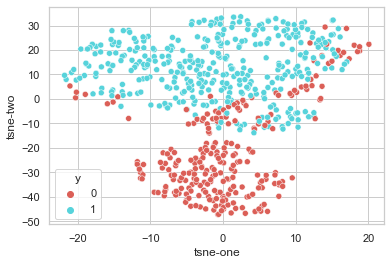

In [12]:
# K-means
model = KMeans(n_clusters=2, init='k-means++', random_state=0)
model.fit(x)
km_labels = model.predict(x)
visualize_clusters(x, km_labels)

Как мы видим, в целом кластеры действительно имеют компактную форму и могут быть разделены. Если бы кластеры не были сформированы должным образом и если бы tSNE преобразовал точки данных, которые мы разрежаем и распределяем, мы могли бы предположить, что любой алгоритм классификации также может потерпеть неудачу. Но в этом случае, за исключением нескольких точек данных, большинство точек являются частью двух сформированных различимых кластеров. Более подробный сравнительный анализ может быть проведен для выявления ключевой информации о тех точках, которые не являются частью правильных кластеров. Но мы не будем описывать их в этой тетради, чтобы упростить задачу!


$$ Comparison~ Analysis~ for~ time~ series~ data $$

In [15]:
plt.rcParams["figure.figsize"] = (15,5)
series = pd.read_csv('C:\\Users\\1\\Downloads\\daily-total-female-births-CA.csv', header=0, index_col=0)
series.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


<AxesSubplot:xlabel='date'>

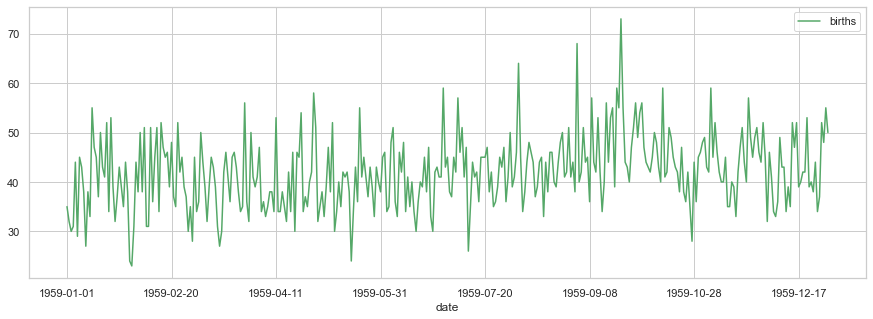

In [16]:
series.plot(color = 'g')

In [21]:
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(2,1,1)) # Simple ARIMA time series forecast model
model_fit = model.fit()
# forecast
forecast = model_fit.predict(start=366, end=466)
for i in range(len(forecast)):
    forecast[i] = random.random() * 10 + forecast[i]
result = model_fit.get_forecast()
con_interval = result.conf_int(0.05)

In [22]:
forecast_ub = forecast + 0.5 * con_interval[0][1] # Upper bound and lower bound of confidence interval
forecast_lb = forecast - 0.5 * con_interval[0][0]

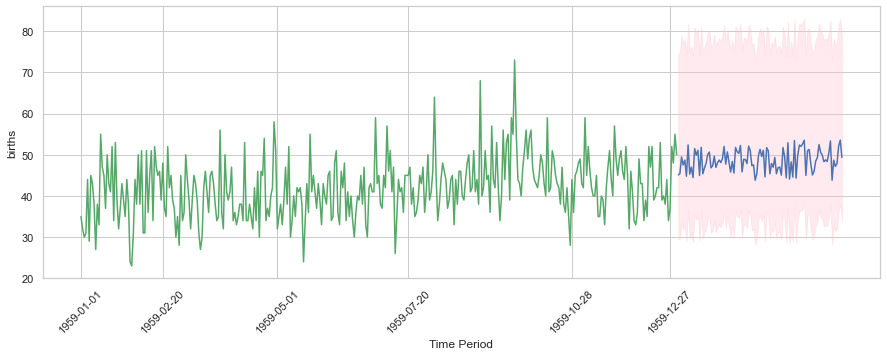

In [24]:
plt.plot(series.index, series['births'], color = 'g')
plt.plot(list(range(len(series.index), len(series.index)+101)),forecast, color = 'b')
plt.fill_between(list(range(len(series.index), len(series.index)+101)), forecast_lb, forecast_ub, alpha = 0.3, color = 'pink')
plt.xlabel('Time Period')
plt.xticks([0, 50, 120, 200, 300, 360],[series.index[0],series.index[50], series.index[120], series.index[200], series.index[300], series.index[360]] ,rotation=45)
plt.ylabel('births')
plt.show()

Из приведенного выше графика мы можем видеть доверительную полосу вокруг прогнозируемых значений. Хотя наша модель не очень точна, но мы сосредоточены на понимании важности сравнительного анализа. Доверительный интервал дает нам четкое представление о диапазоне значений, которые может принимать прогноз. Таким образом, это помогает установить правильное ожидание наилучшего и наихудшего сценария и является довольно эффективным, а не просто одноточечной оценкой. Даже если фактический прогноз модели неверен, доверительный интервал, показывающий возможный диапазон значений, может предотвратить любой шок для конечных заинтересованных сторон и в конечном итоге может сделать модель более надежной.

### $$ Result~ Visualizations~ with~ Surrogate~ Explainers $$

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
np.random.seed(5)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
#import xgboost as xgb
import sklearn
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from skrules import SkopeRules
#from dtreeviz.trees import dtreeviz
#import graphviz

In [38]:
import sys
!{sys.executable} -m pip install xgboost

  Using cached xgboost-1.6.1-py3-none-win_amd64.whl (125.4 MB)


In [39]:
import sys
!{sys.executable} -m pip install dtreeviz

  Using cached dtreeviz-1.3.7.tar.gz (62 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached colour-0.1.5-py2.py3-none-any.whl (23 kB)
  Created wheel for dtreeviz: filename=dtreeviz-1.3.7-py3-none-any.whl size=68151 sha256=0afb5e3e62402542eb25ee76e187e07e148ae6922bd3fbd1d2924e20c1030fda
  Stored in directory: c:\users\1\appdata\local\pip\cache\wheels\94\4d\ca\df6b7427d49df660c50c351242463476c3f7935c359402e42b
Successfully built dtreeviz


In [46]:
from dtreeviz.trees import dtreeviz
import graphviz
import xgboost as xgb

О данных
Набор данных для взрослых - Репозиторий машинного обучения UCI
Этот набор данных также известен как набор данных о доходах переписи, который используется для прогнозирования того, превышает ли доход 50 тыс. долларов в год на основе данных переписи. Это многомерный набор данных, используемый для задач, основанных на классификации, содержащий 14 различных признаков.

In [53]:
data  = pd.read_csv('C:\\Users\\1\\Downloads\\adult_census.csv', header=None)
data.columns = ['Age','Workclass','fnlwgt','Education','Education-Num','Marital Status','Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss','Hours per week','Country','AnnualIncome'].copy()
data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,AnnualIncome
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [54]:
data.shape

(32561, 15)

In [55]:
features = data.iloc[:,:-1]
labels = data.iloc[:,-1]
labels.value_counts()

 <=50K    24720
 >50K      7841
Name: AnnualIncome, dtype: int64

In [56]:
labels = labels.apply(lambda x: 1 if x == ' >50K' else 0)

In [57]:
features = pd.get_dummies(features)
features.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
labels.value_counts()

0    24720
1     7841
Name: AnnualIncome, dtype: int64

In [59]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=30)

In [47]:
classifier = xgb.XGBClassifier(n_estimators=400, max_depth=10, base_score=0.5, objective='binary:logistic', random_state=30)
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=30,
              reg_alpha=0, reg_lambda=1, ...)

In [48]:
classifier.score(x_test, y_test)

0.8615077537233226

In [49]:
import sys
!{sys.executable} -m pip install imodels


ERROR: Could not install packages due to an OSError: HTTPSConnectionPool(host='files.pythonhosted.org', port=443): Max retries exceeded with url: /packages/f1/74/4c190322f8beeb9a3813d9c82b7a0e84c944f4e2165f59e5c735d743a82a/imodels-1.3.3-py3-none-any.whl (Caused by NewConnectionError('<pip._vendor.urllib3.connection.HTTPSConnection object at 0x000002645E66D250>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))



In [51]:
pip install imodels

  Using cached imodels-1.3.3-py3-none-any.whl (192 kB)
  Using cached mlxtend-0.20.0-py2.py3-none-any.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [52]:
from imodels import SLIMRegressor, BayesianRuleListClassifier, RuleFitRegressor, GreedyRuleListClassifier
from imodels import SLIMClassifier, OneRClassifier, BoostedRulesClassifier
from imodels.util.convert import tree_to_code

In [65]:
from sklearn import metrics

In [66]:
def viz_classification_preds(probs, y_test):
    '''look at prediction breakdown
    '''
    plt.subplot(121)
    plt.hist(probs[:, 1][y_test==0], label='Class 0')
    plt.hist(probs[:, 1][y_test==1], label='Class 1', alpha=0.8)
    plt.ylabel('Count')
    plt.xlabel('Predicted probability of class 1')
    plt.legend()
    
    plt.subplot(122)
    preds = np.argmax(probs, axis=1)
    plt.title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.tight_layout()
    plt.show()

> ------------------------------
> BoostedRules:
> 	Rule → predicted probability (final prediction is weighted sum of all predictions)
> ------------------------------
  If Marital Status_ Married-civ-spouse <= 0.5 → 0.00 (weight: 0.57)
  If Marital Status_ Married-civ-spouse > 0.5 → 0.46 (weight: 0.56)
  If Marital Status_ Married-civ-spouse <= 0.5 → 0.25 (weight: 0.43)
  If Marital Status_ Married-civ-spouse > 0.5 → 0.05 (weight: 0.18)
  If Education-Num <= 12.5 → 0.73 (weight: 0.32)
  If Education-Num > 12.5 → 0.05 (weight: 0.20)
  If Capital Gain <= 5119.0 → 1.00 (weight: 0.11)
  If Capital Gain > 5119.0 → 0.04 (weight: 0.09)
  If Age <= 28.5 → 0.29 (weight: 0.18)
  If Age > 28.5 → 1.00 (weight: 0.13)



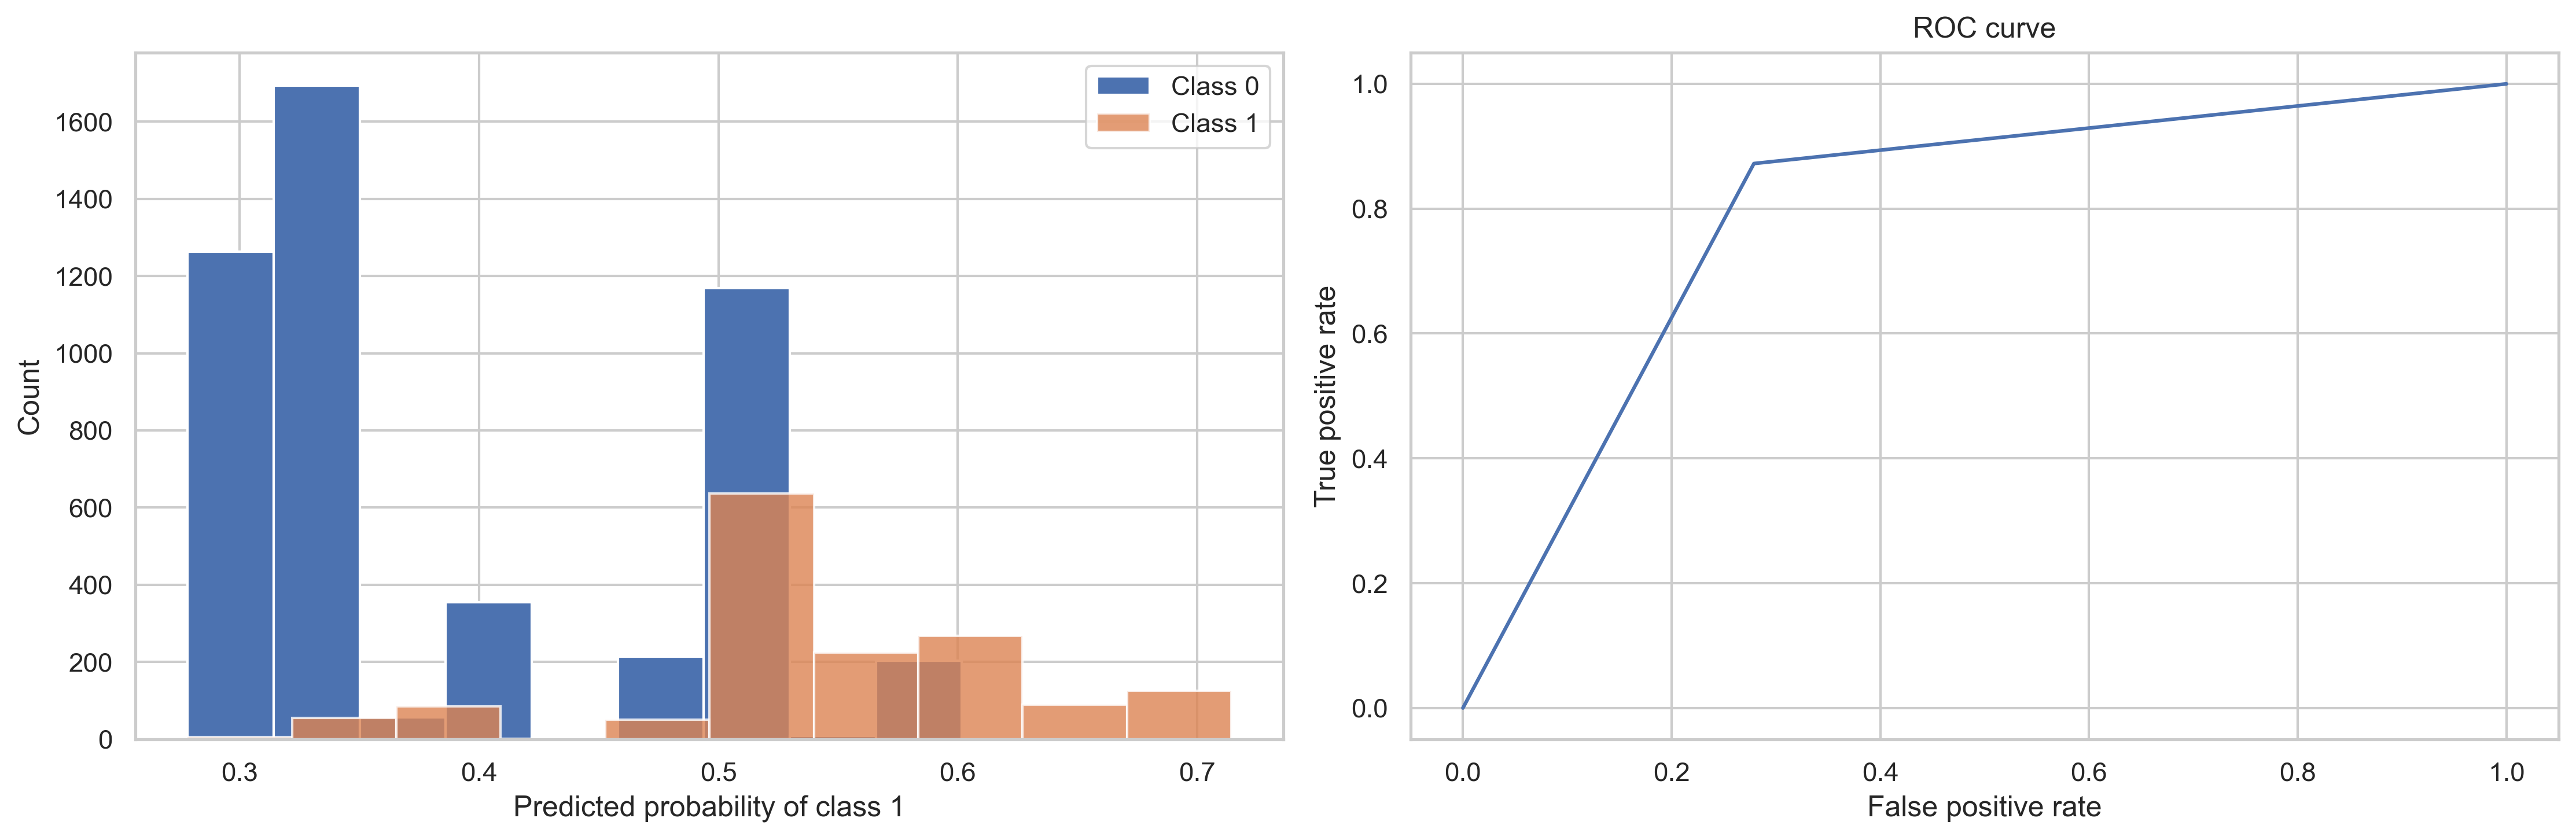

In [67]:
brc = BoostedRulesClassifier(n_estimators=10)
brc.fit(x_train, y_train, feature_names=list(x_train.columns))

print(brc)

# look at performance
probs = brc.predict_proba(x_test)
viz_classification_preds(probs, y_test)

### $$ Feature Importance and Sensitivity Analysis $$

In [68]:
import sys
!{sys.executable} -m pip install tensorflow

  Using cached tensorflow-2.9.1-cp39-cp39-win_amd64.whl (444.0 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached absl_py-1.2.0-py3-none-any.whl (123 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached libclang-14.0.6-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
np.random.seed(5)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Reshape, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

C:\Users\1\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\1\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [70]:
data  = pd.read_csv('C:\\Users\\1\\Downloads\\diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data Distribution


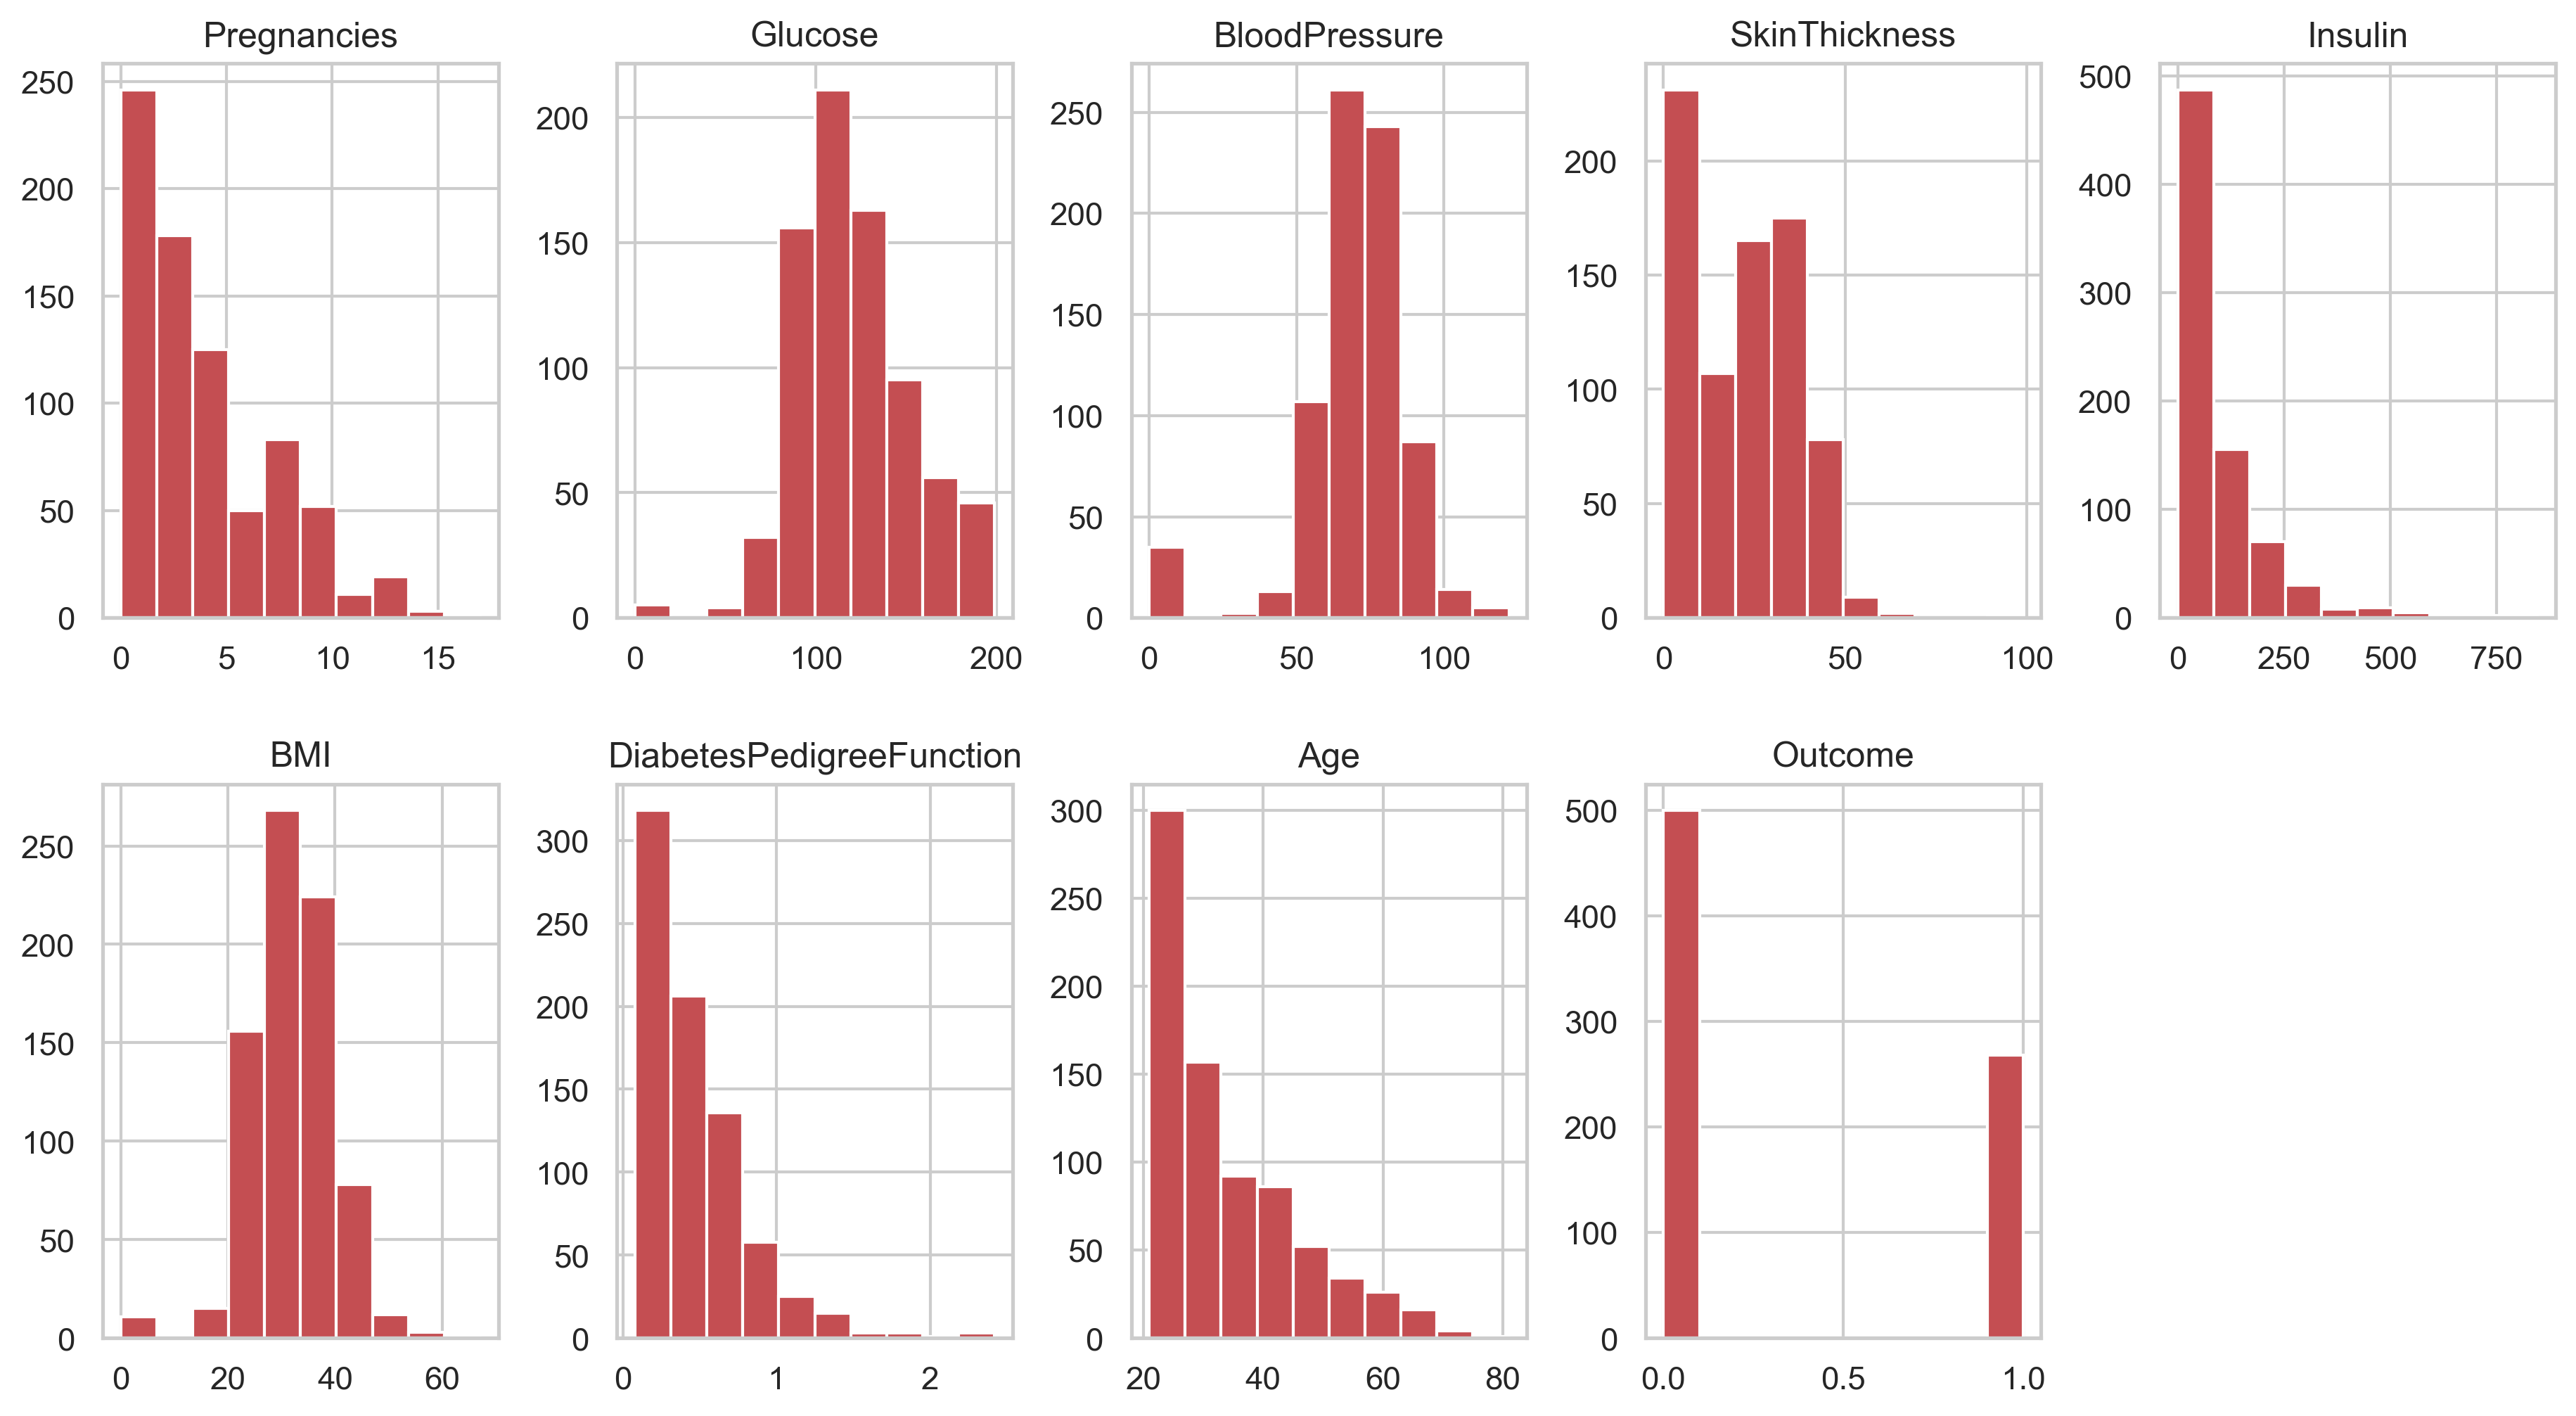

In [71]:
data.hist(layout = (2,5), figsize=(15,8), color = 'r')
print('Data Distribution')

This looks like a fairly imbalanced dataset


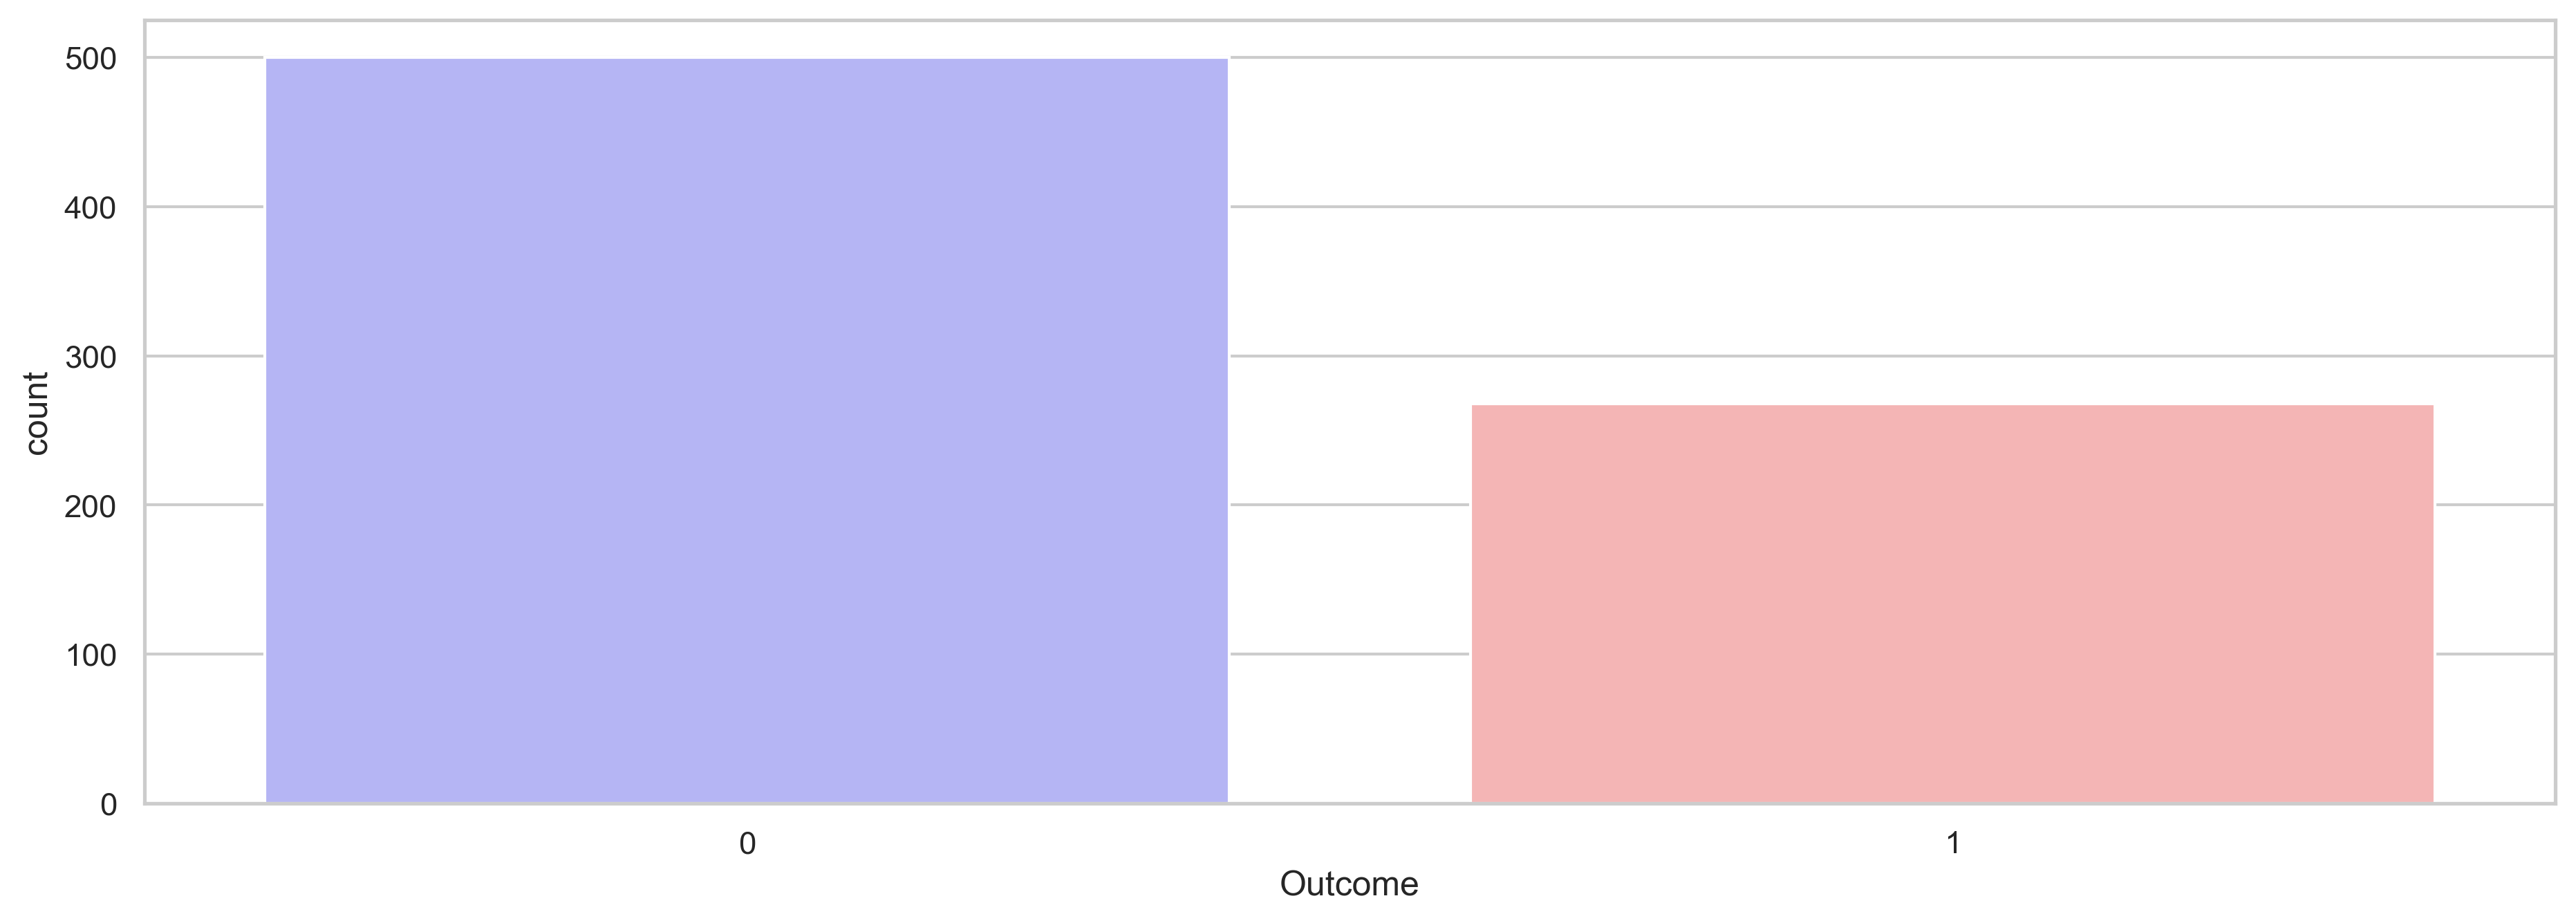

In [72]:
print('This looks like a fairly imbalanced dataset')
sns.countplot(x="Outcome", data=data, palette="bwr")
plt.show()

In [73]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [74]:
print('Percentage of data belonging to class 1 is',int((268/768)*100))
print('Percentage of data belonging to class 0 is',int((500/768)*100))

Percentage of data belonging to class 1 is 34
Percentage of data belonging to class 0 is 65


In [75]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [76]:
data.duplicated().any()

False

In [77]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Из этого описания данных вытекают два основных замечания:
Есть несколько записей, для которых ИМТ, уровень глюкозы, кровяное давление равны 0. Возможно, эти значения не были записаны должным образом в процессе сбора данных. Таким образом, лучше не рассматривать эти строки для целей обучения.
Наблюдаются некоторые отклонения от максимальных значений в количестве Беременностей, Толщине кожи, инсулине и т.д., Что требует дальнейшего изучения.

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64


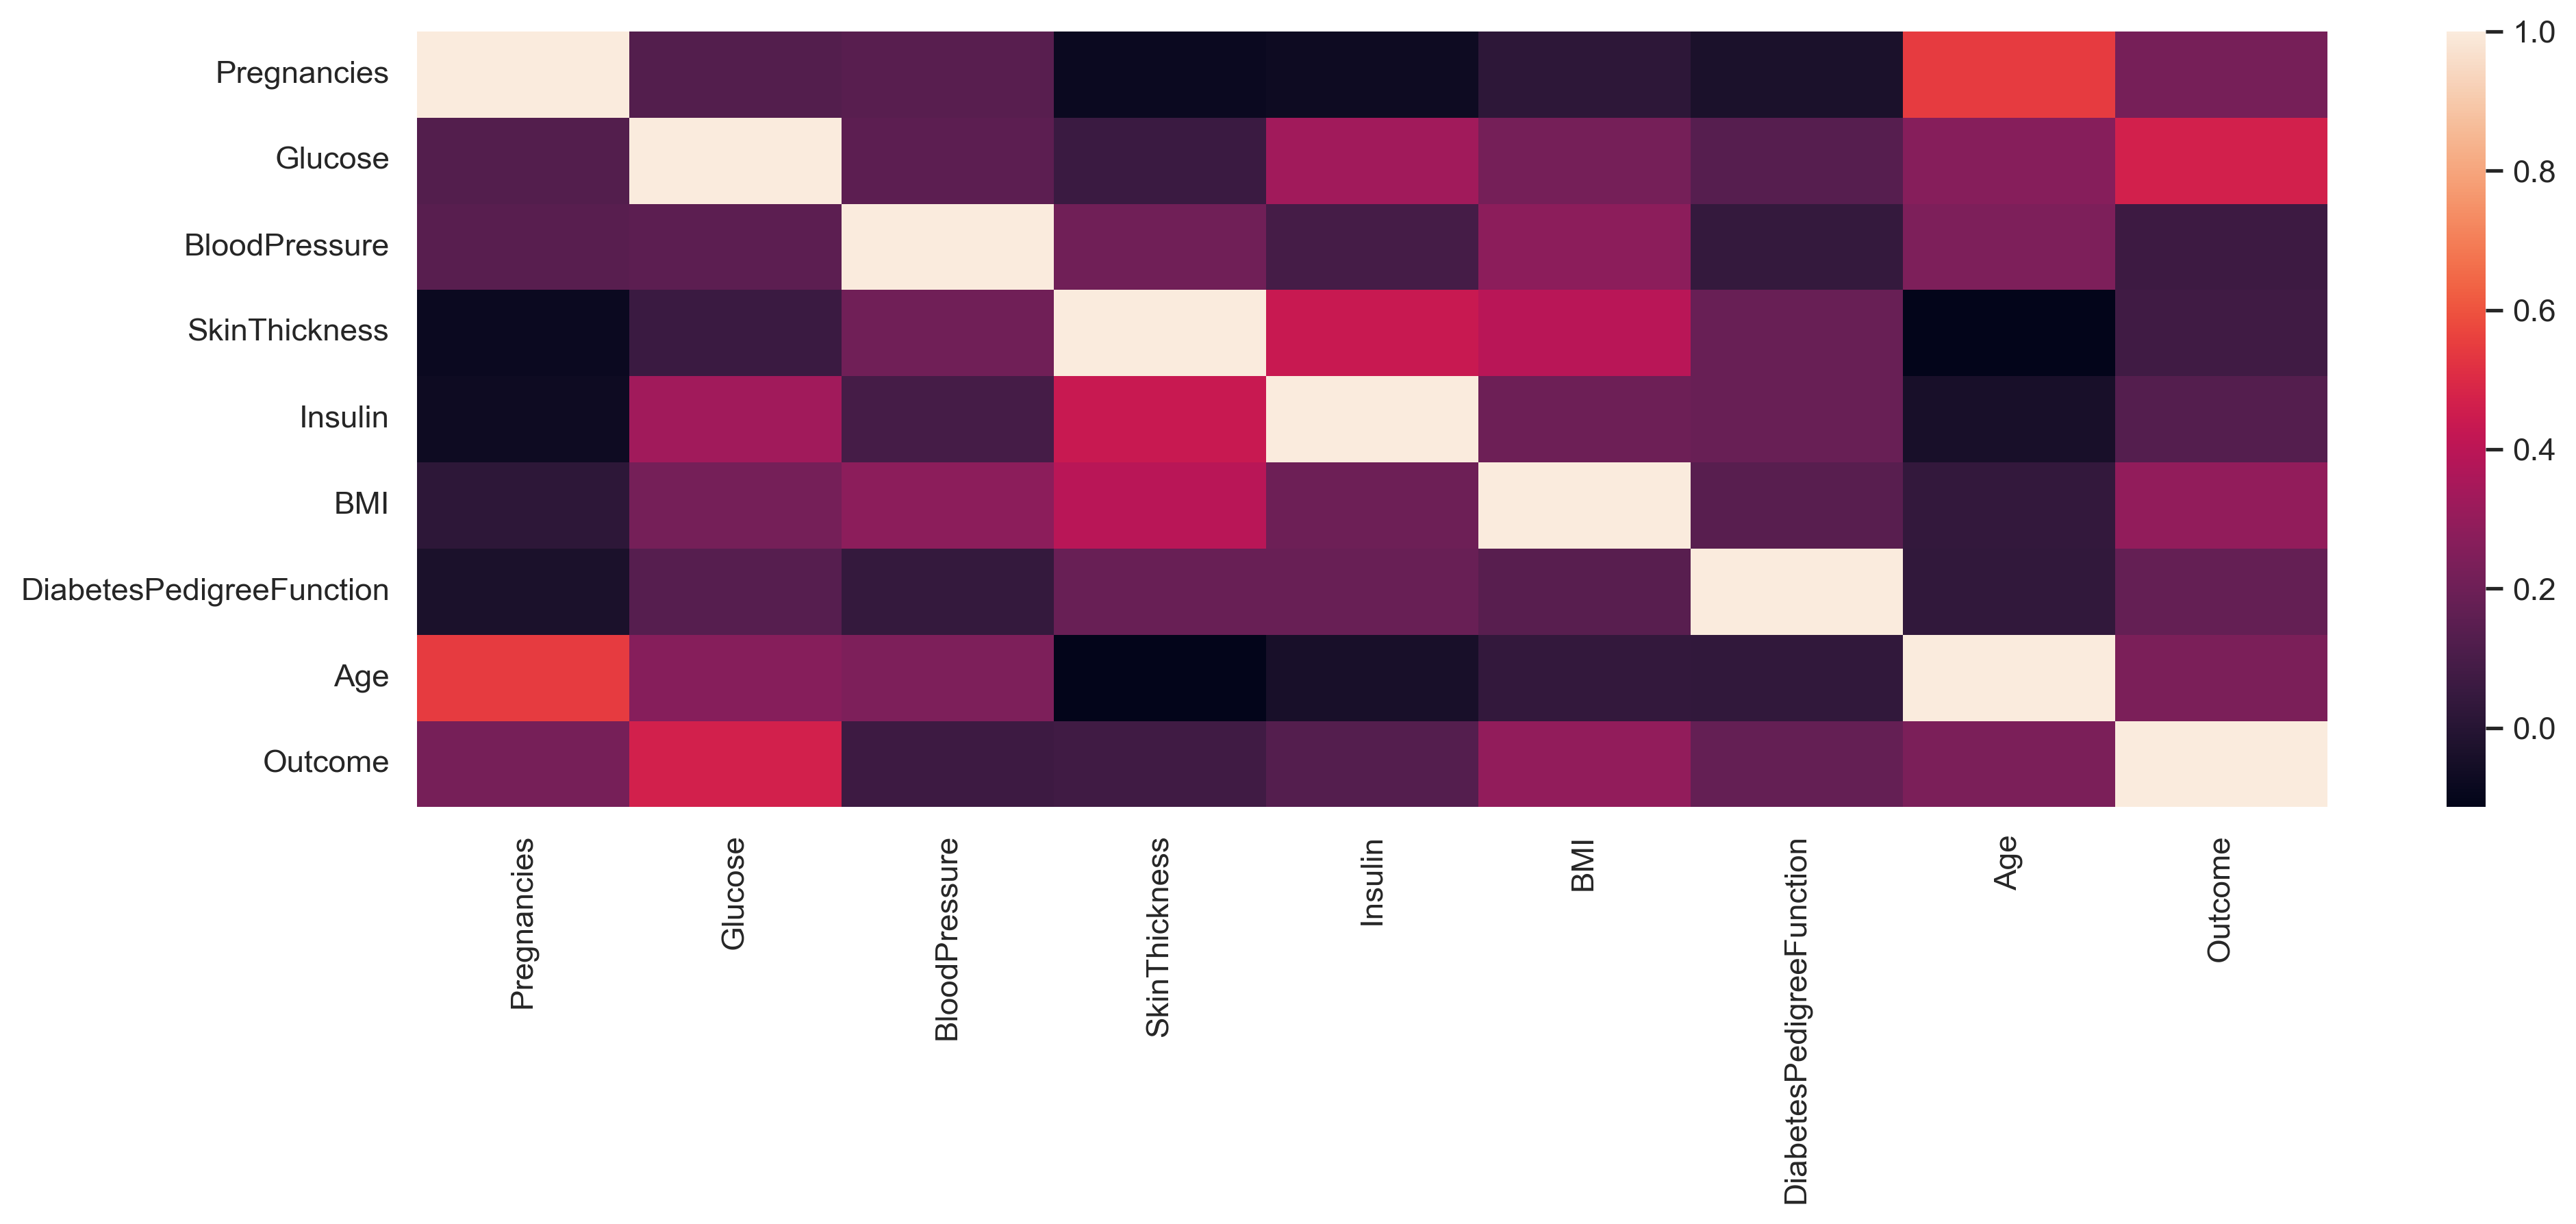

In [78]:
print(data.corr()['Outcome'])
sns.heatmap(data.corr())
plt.show()

Замечено, что характеристики не имеют сильной корреляции (>0,5) с целевой переменной.

In [79]:
data[(data['BMI'] == 0) & (data['Glucose'] == 0) & (data['BloodPressure'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [80]:
data[(data['Glucose'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


Из приведенного выше наблюдения видно, что в данных действительно много шума, поскольку существует множество случаев, когда некоторые ключевые характеристики равны 0. Но, следуя человеческой интуиции, поскольку уровень глюкозы в крови является одним из ключевых показателей для наблюдения за диабетом, я бы подумал о том, чтобы удалить все записи, где значение глюкозы равно 0.

In [81]:
cleaned_data = data[(data['Glucose'] != 0)]
cleaned_data.shape

(763, 9)

In [82]:
feature_engg_data = cleaned_data.copy()
outlier_data = cleaned_data.copy()
factor = 3
# Include this only for columns with suspected outliers
# Using a factor of 3, following Nelson's rule 1 to remove outliers - https://en.wikipedia.org/wiki/Nelson_rules
# Only for non-categorical fields
columns_to_include = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
for column in columns_to_include:
    upper_lim = feature_engg_data[column].mean () + feature_engg_data[column].std () * factor
    lower_lim = feature_engg_data[column].mean () - feature_engg_data[column].std () * factor
    feature_engg_data = feature_engg_data[(feature_engg_data[column] < upper_lim) & (feature_engg_data[column] > lower_lim)]
    
outlier_data = pd.concat([outlier_data, feature_engg_data]).drop_duplicates(keep=False)

print(feature_engg_data.shape)
print(outlier_data.shape)

(688, 9)
(75, 9)


В следующем разделе для построения модели нам нужно будет нормализовать данные и разделить их на обучающий, валидационный и тестовый набор данных. Данные о выбросах, которые у нас есть, мы будем хранить отдельно, на всякий случай, чтобы посмотреть, как наша модель работает с набором данных о выбросах.

In [83]:
def normalize_data(df):
    val = df.values 
    min_max_normalizer = preprocessing.MinMaxScaler()
    norm_val = min_max_normalizer.fit_transform(val)
    df2 = pd.DataFrame(norm_val, columns=df.columns)
    
    return df2

norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

In [84]:
input_data = norm_feature_engg_data.drop(['Outcome'],axis='columns')
targets =norm_feature_engg_data.filter(['Outcome'],axis='columns')

x, x_test, y, y_test = train_test_split(input_data,targets,test_size=0.1,train_size=0.9, random_state=5)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.22,train_size =0.78, random_state=5)

In [85]:
def apply_RFC(X,y,columns):
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
    imp_features = rfc.fit(X,y).feature_importances_ 
    imp_features = pd.DataFrame(imp_features,columns=['Feature Importance'],index=columns)
    imp_features.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp_features['Moving Sum'] = imp_features['Feature Importance'].cumsum()
    imp_features = imp_features[imp_features['Moving Sum']<=0.95]
    top_features = imp_features.index.tolist()
    return imp_features, top_features

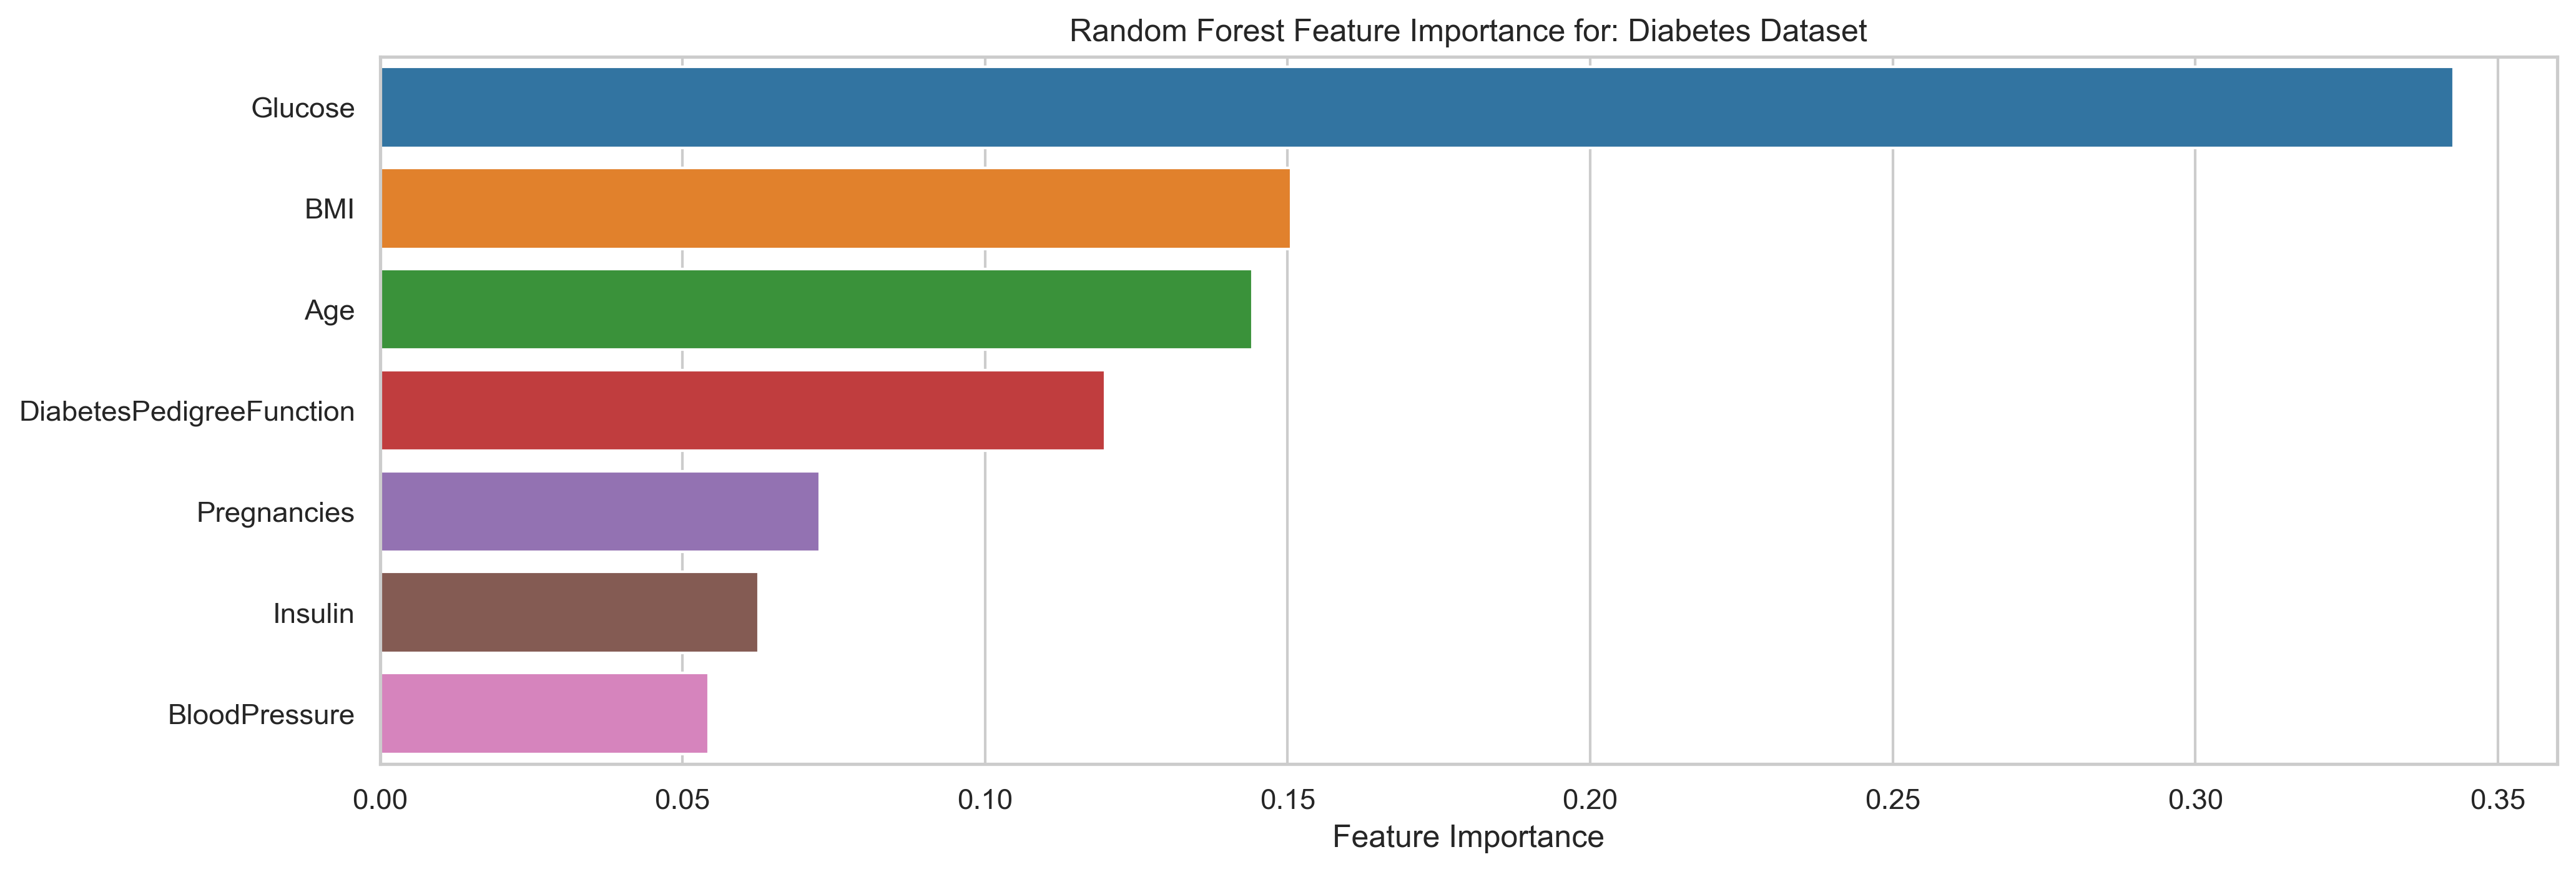

In [86]:
important_features, top_features = apply_RFC(x,y, data.columns.drop('Outcome'))
sns.barplot(important_features['Feature Importance'], important_features.index, palette = 'tab10')
plt.title('Random Forest Feature Importance for: '+"Diabetes Dataset")
plt.show()

из приведенного выше графика мы можем видеть, что уровень глюкозы или количество глюкозы в крови является наиболее важным показателем для определения наличия диабета. ИМТ и возраст также могут играть жизненно важную роль в определении наличия диабета. Это наблюдение вполне согласуется с нашими предыдущими знаниями в области выявления диабета. Это очень полезно для интерпретируемости модели, поскольку, с логической точки зрения, уровень глюкозы в крови играет максимальную роль для выявления диабета.

Sensitivity Analysis

Анализ чувствительности - это количественный процесс, который аппроксимирует неопределенность в прогнозах путем изменения допущений, сделанных в отношении важных входных характеристик, используемых моделью прогнозирования. При анализе чувствительности отдельные переменные входных характеристик увеличиваются или уменьшаются для оценки влияния отдельных характеристик на целевой результат. Хотя я наблюдал, как эксперты применяли анализ чувствительности для обучения и переобучения модели. Но мы применим анализ чувствительности к обученной модели, чтобы оценить чувствительность функций к целевому результату и то, как его можно использовать в качестве независимого от модели метода локальной объяснимости для объяснения моделей черного ящика. Мы применим правило вариации 6-σ (шесть сигм) для анализа чувствительности к задаче классификации выявления диабета.

In [88]:
# For this we need a trained model. So, let's train a model first, may be with a neural network architecture.

def model():
    '''
    Simple 3 layered Neural Network model for binary classification
    '''
    inp = Input(shape=(x_train.shape[1],))
    x = Dense(40, activation='relu')(inp)
    x = Dense(40, activation='relu')(x)
    op = Dense(2, activation='softmax')(x)
    model = Model(inputs=inp, outputs=op)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = model()
model.fit(x_train, to_categorical(y_train), batch_size=64, epochs=300, verbose=0)

In [89]:
# Evaluate the trained model
model.evaluate(x_test, to_categorical(y_test))[1]

3/3 [==============================] - 1s 15ms/step - loss: 0.4705 - accuracy: 0.8116


0.8115941882133484

Хотя мы не беспокоимся о точности конечной модели, но у нас есть достойная модель, на которой можно попробовать провести анализ чувствительности. Далее мы возьмем экземпляр запроса, чтобы выполнить правило вариации 6-σ (шесть сигм) для анализа чувствительности экземпляра запроса.

In [91]:
query_instance = x_test.iloc[5].values.reshape((1,) + x_test.iloc[5].shape)
print("Let's take a look at the normalized query data instance in which all the features are in the range of (0.0 - 1.0):" )
df_query = pd.DataFrame(query_instance, columns = input_data.columns)
df_query

Let's take a look at the normalized query data instance in which all the features are in the range of (0.0 - 1.0):


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.538462,0.883871,0.612245,0.35,0.462651,0.505714,0.384266,0.5


In [92]:
predicted_outcome = np.argmax(model.predict(query_instance))
true_label = int(y_test.iloc[5][0])
print(f" The true label is : {true_label}")
print(f" The predicted outcome is : {predicted_outcome}")

1/1 [==============================] - 0s 311ms/step
 The true label is : 1
 The predicted outcome is : 1


Мы можем ясно видеть, что модель правильно предсказывает наличие диабета. Теперь давайте посмотрим, меняется ли это, когда мы проводим анализ чувствительности, один за другим для всех функций.

Мера стандартного отклонения (σ) может быть рассчитана на основе нормализованных обучающих данных, поскольку мы будем использовать нормализованные данные для части прогнозирования.

In [93]:
sigma_glucose = np.std(x['Glucose'])
sigma_bmi = np.std(x['BMI'])
sigma_age = np.std(x['Age'])
sigma_dpf = np.std(x['DiabetesPedigreeFunction'])
sigma_pregnancies = np.std(x['Pregnancies'])
sigma_insulin = np.std(x['Insulin'])
sigma_bp = np.std(x['BloodPressure'])

1/1 [==============================] - 0s 40ms/step


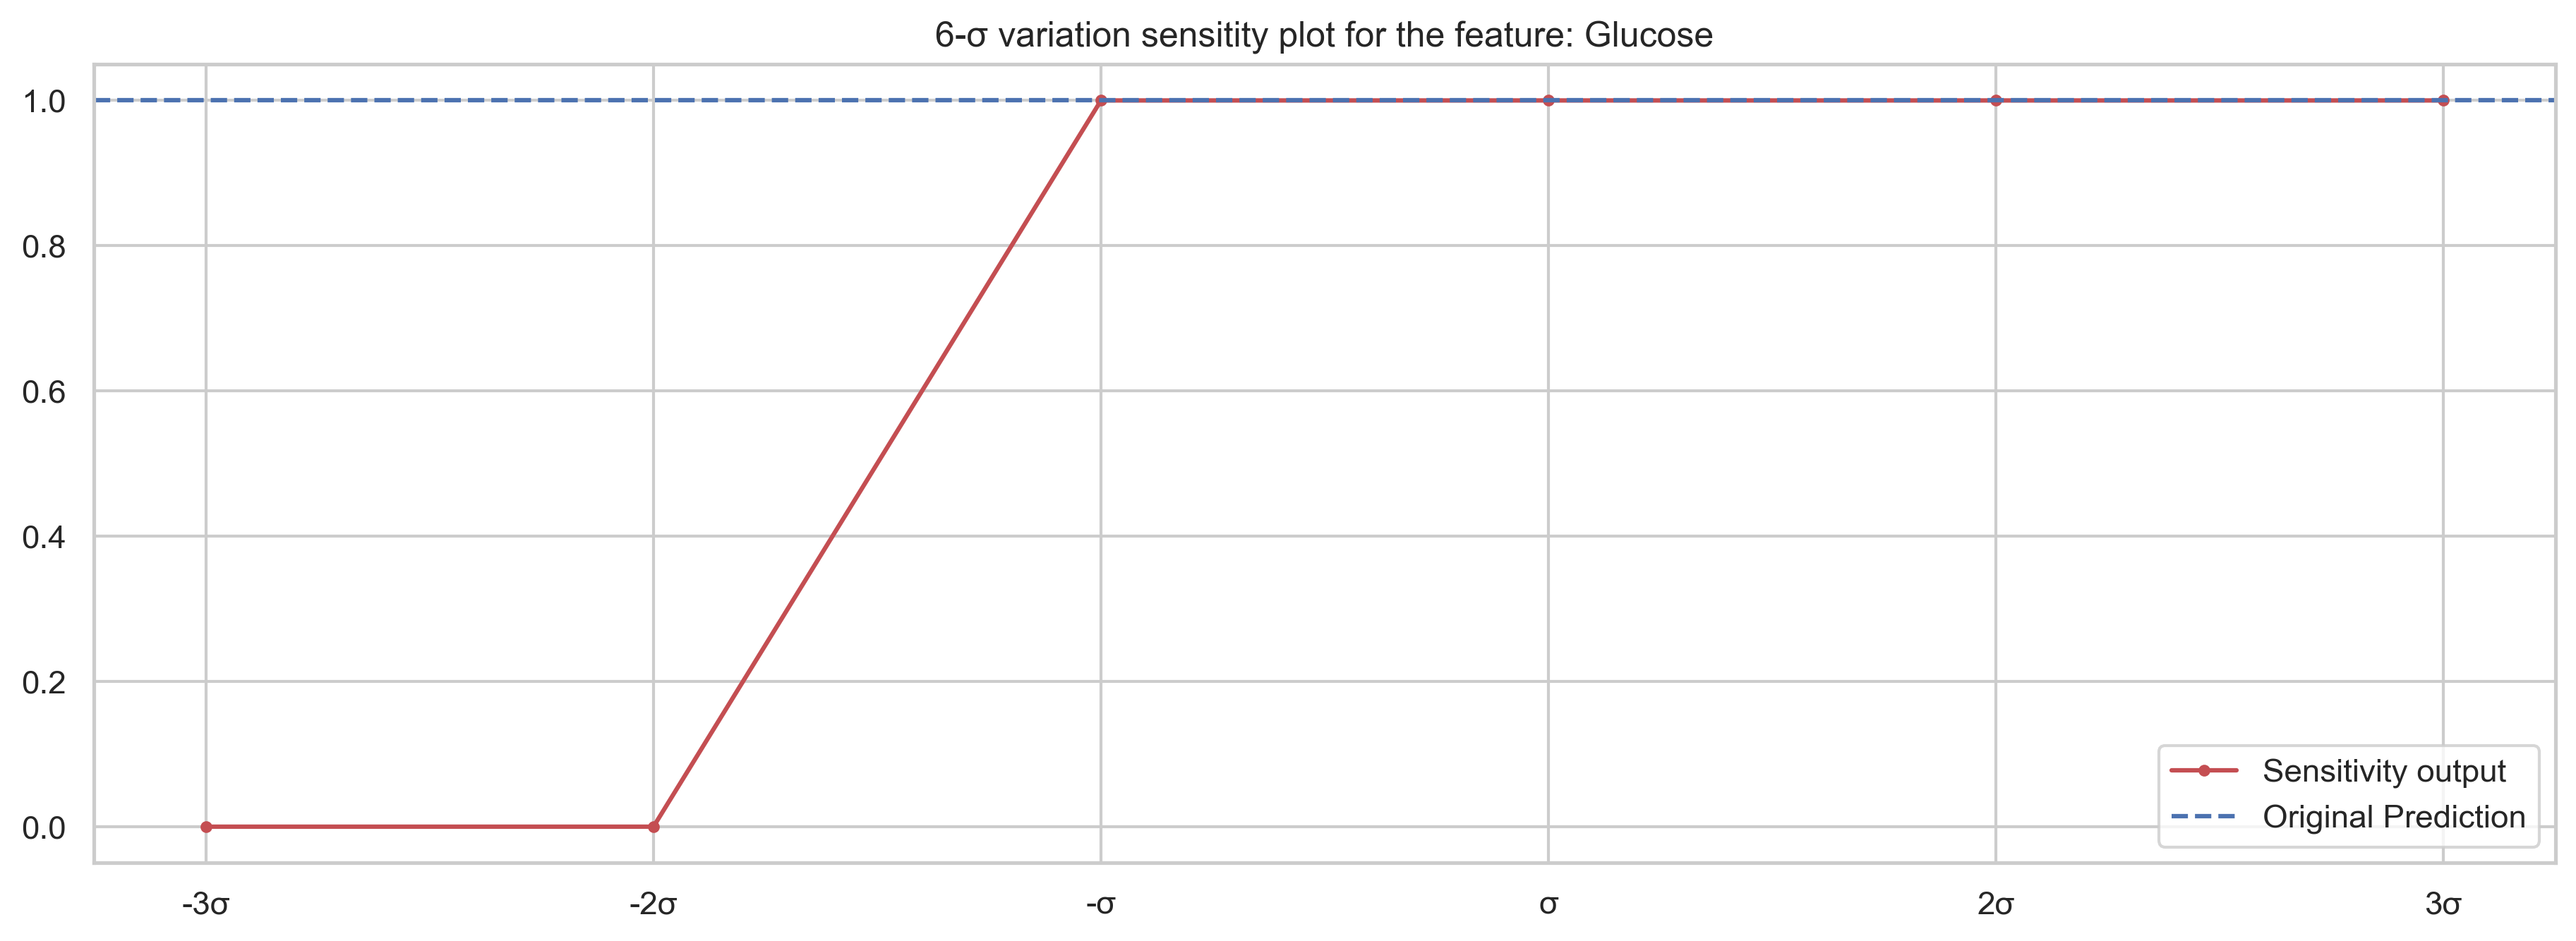

1/1 [==============================] - 0s 44ms/step


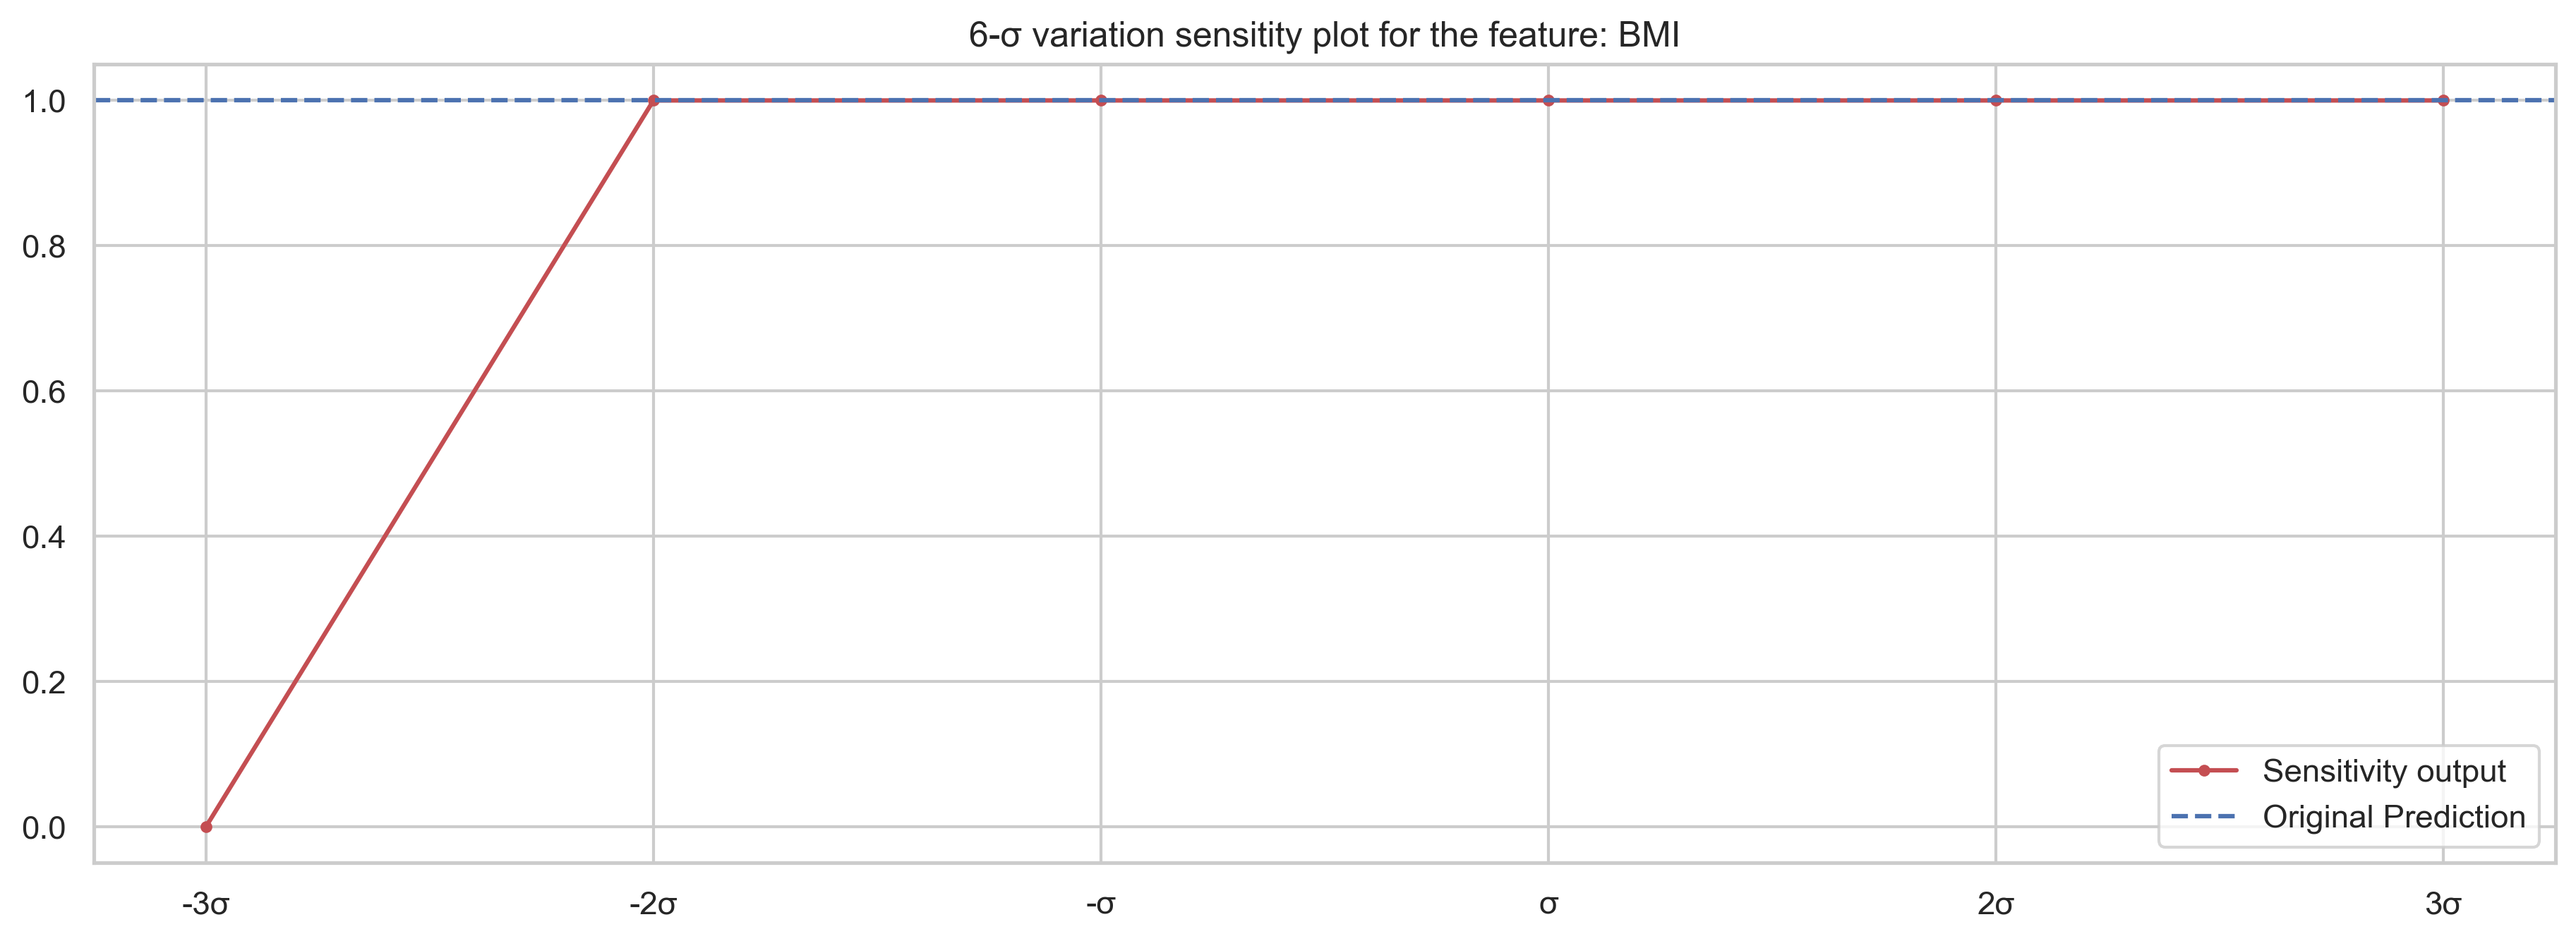

1/1 [==============================] - 0s 45ms/step


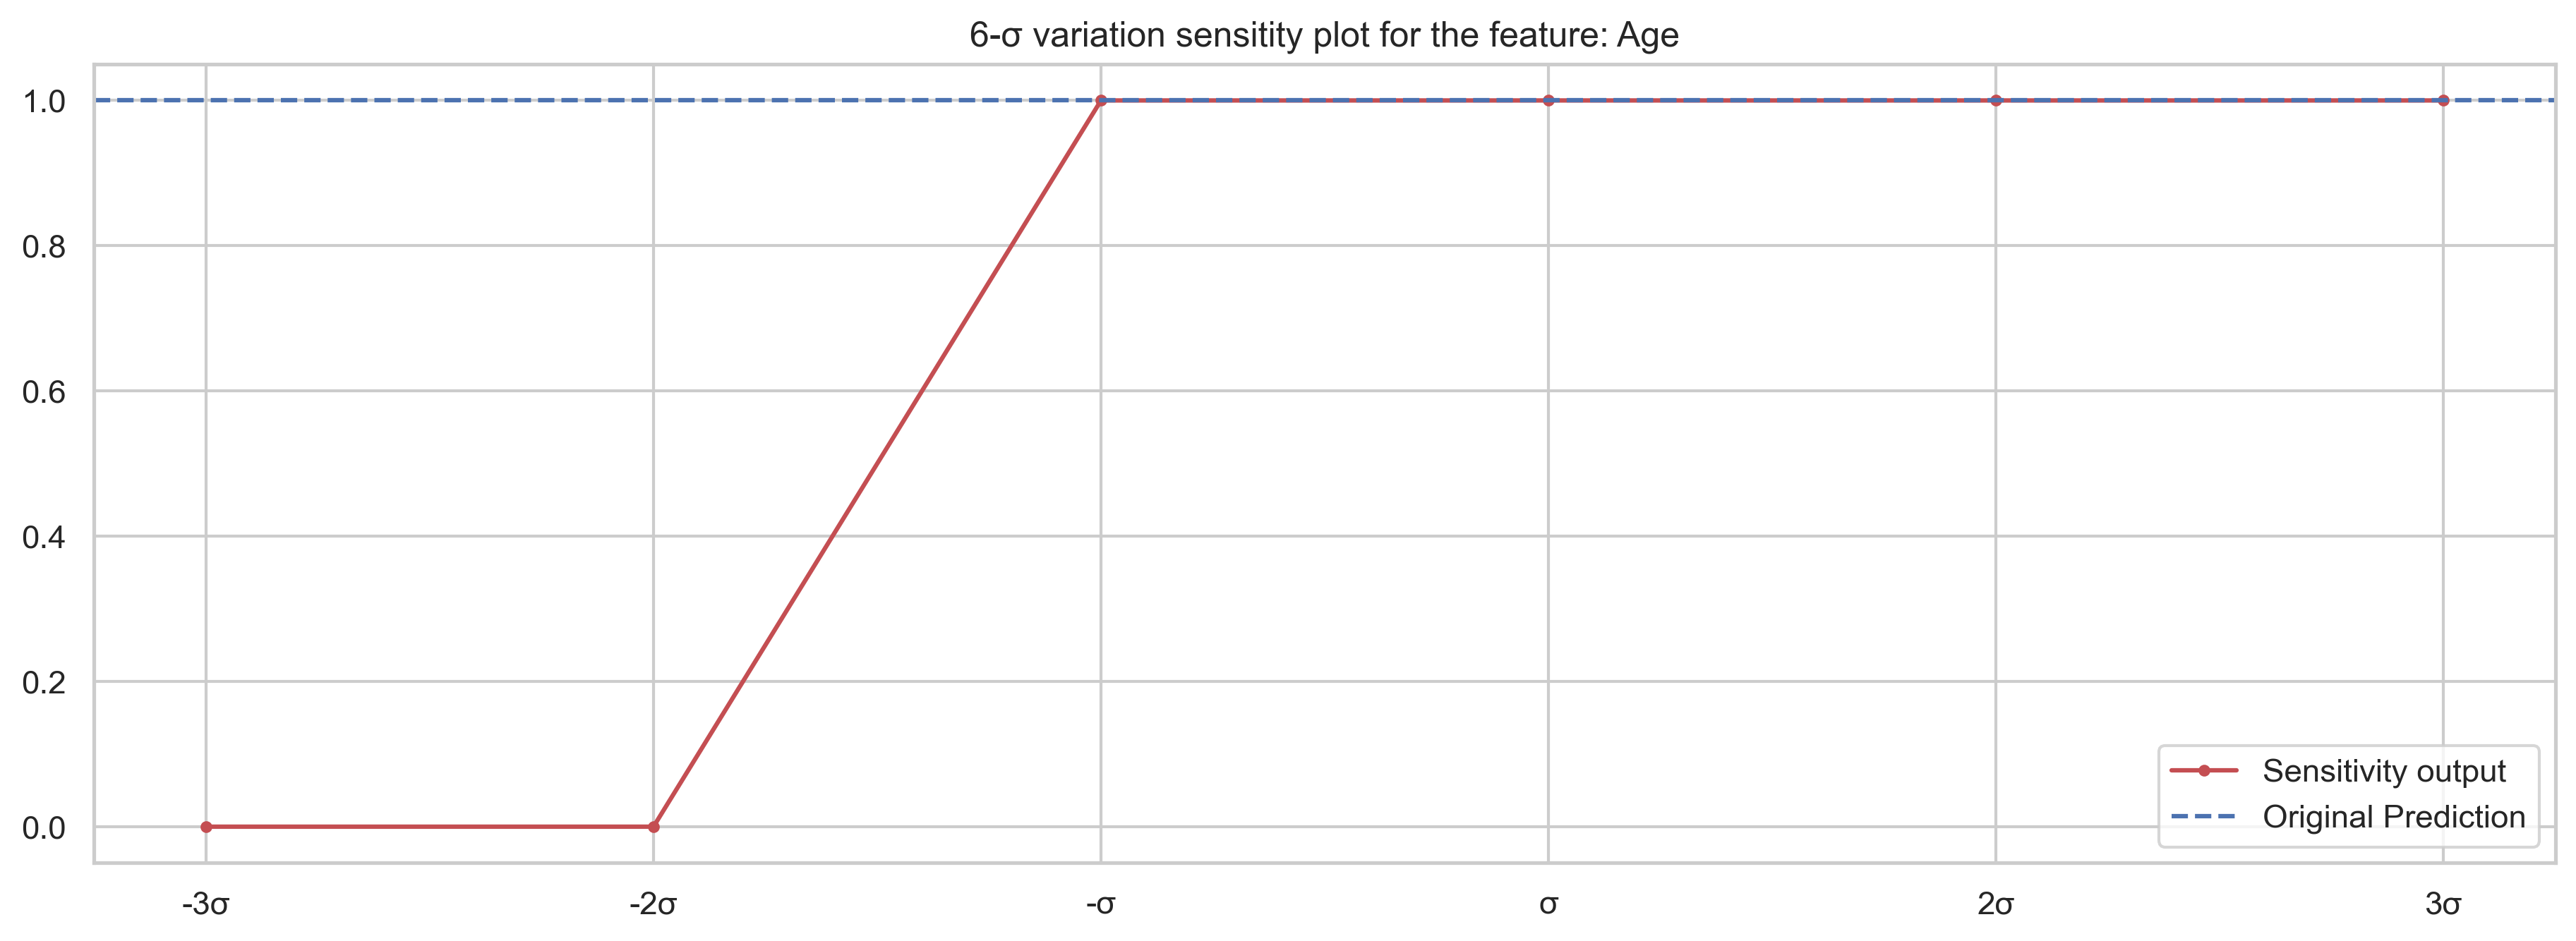

1/1 [==============================] - 0s 54ms/step


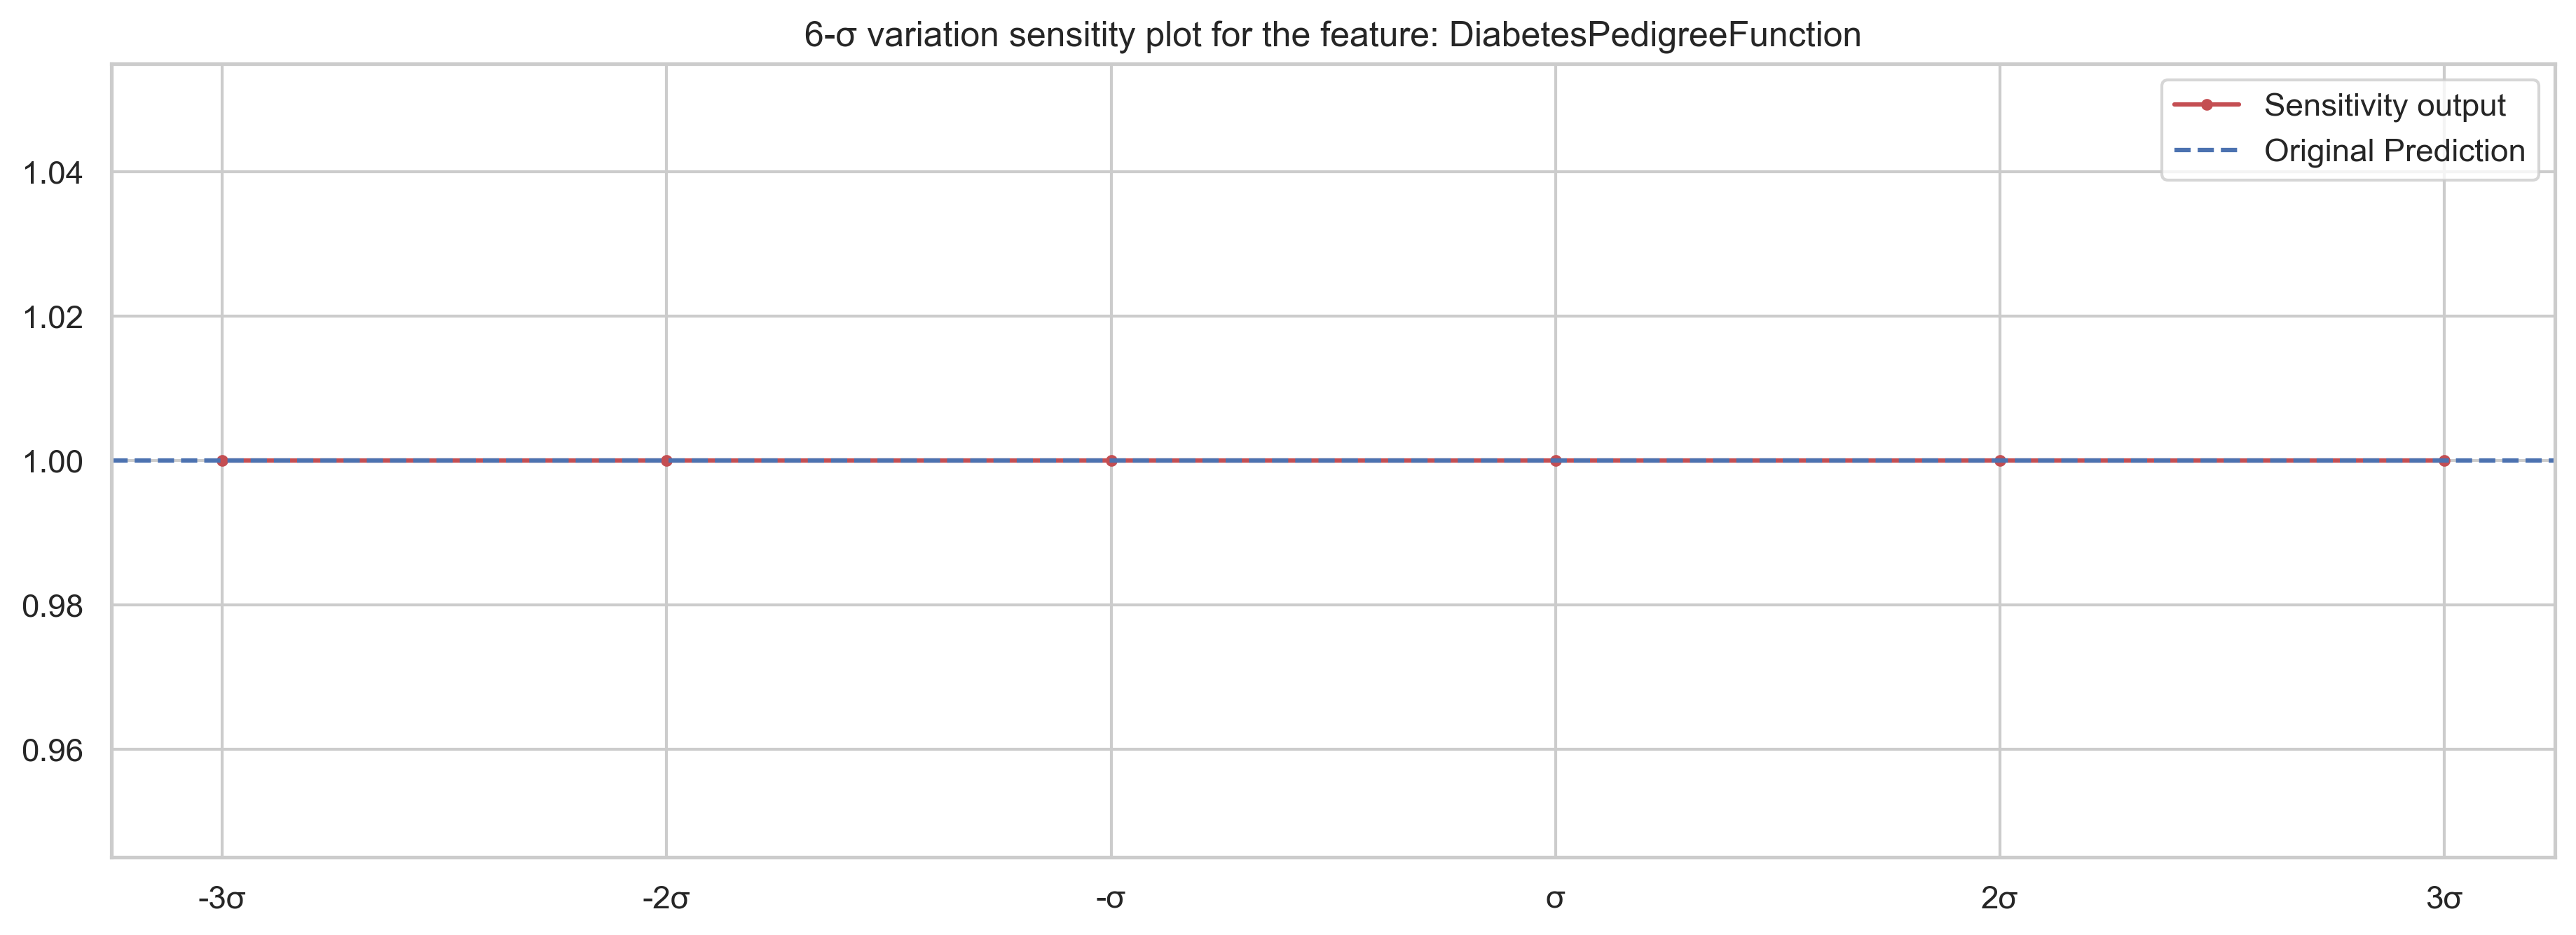

1/1 [==============================] - 0s 40ms/step


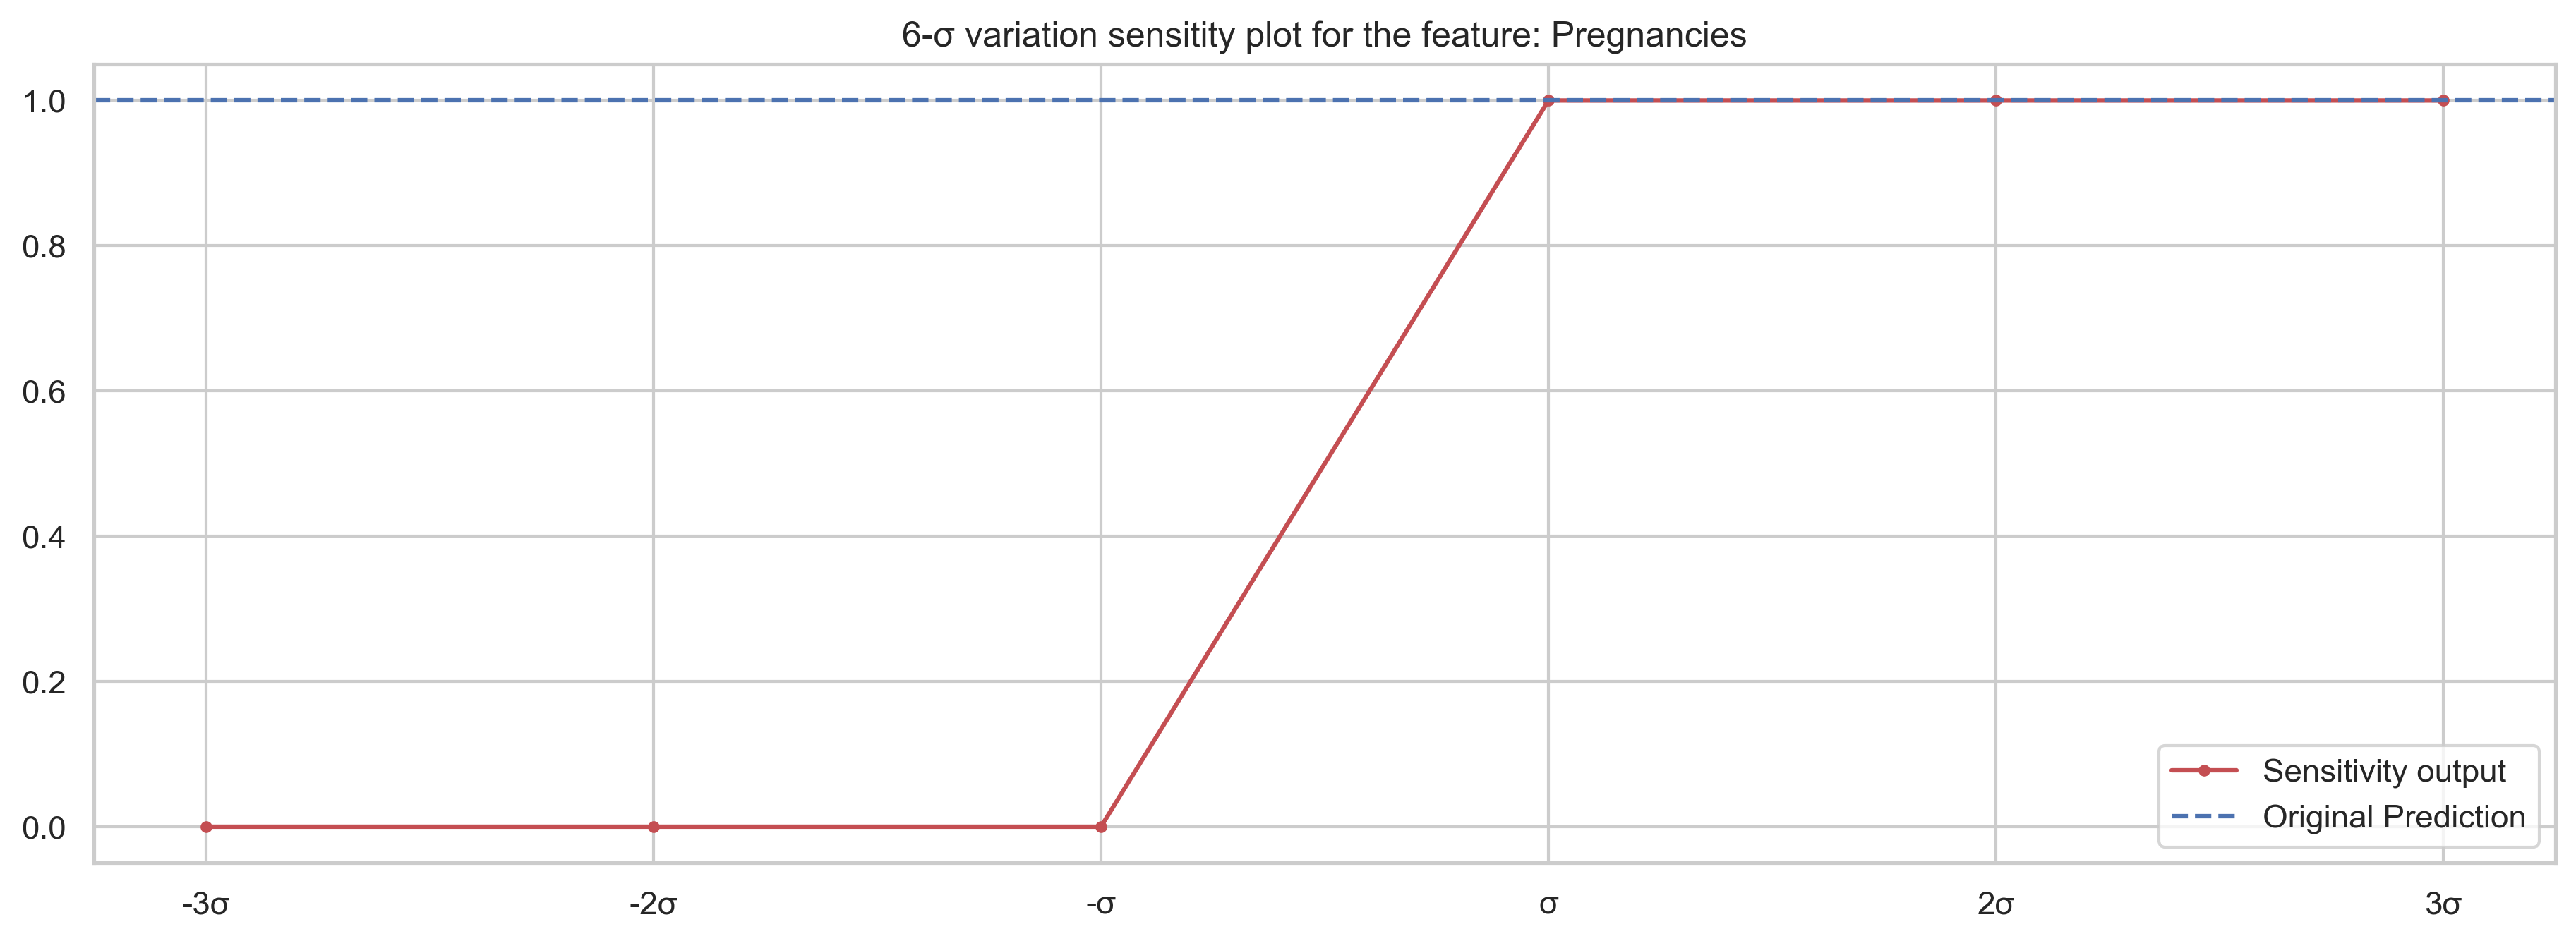

1/1 [==============================] - 0s 49ms/step


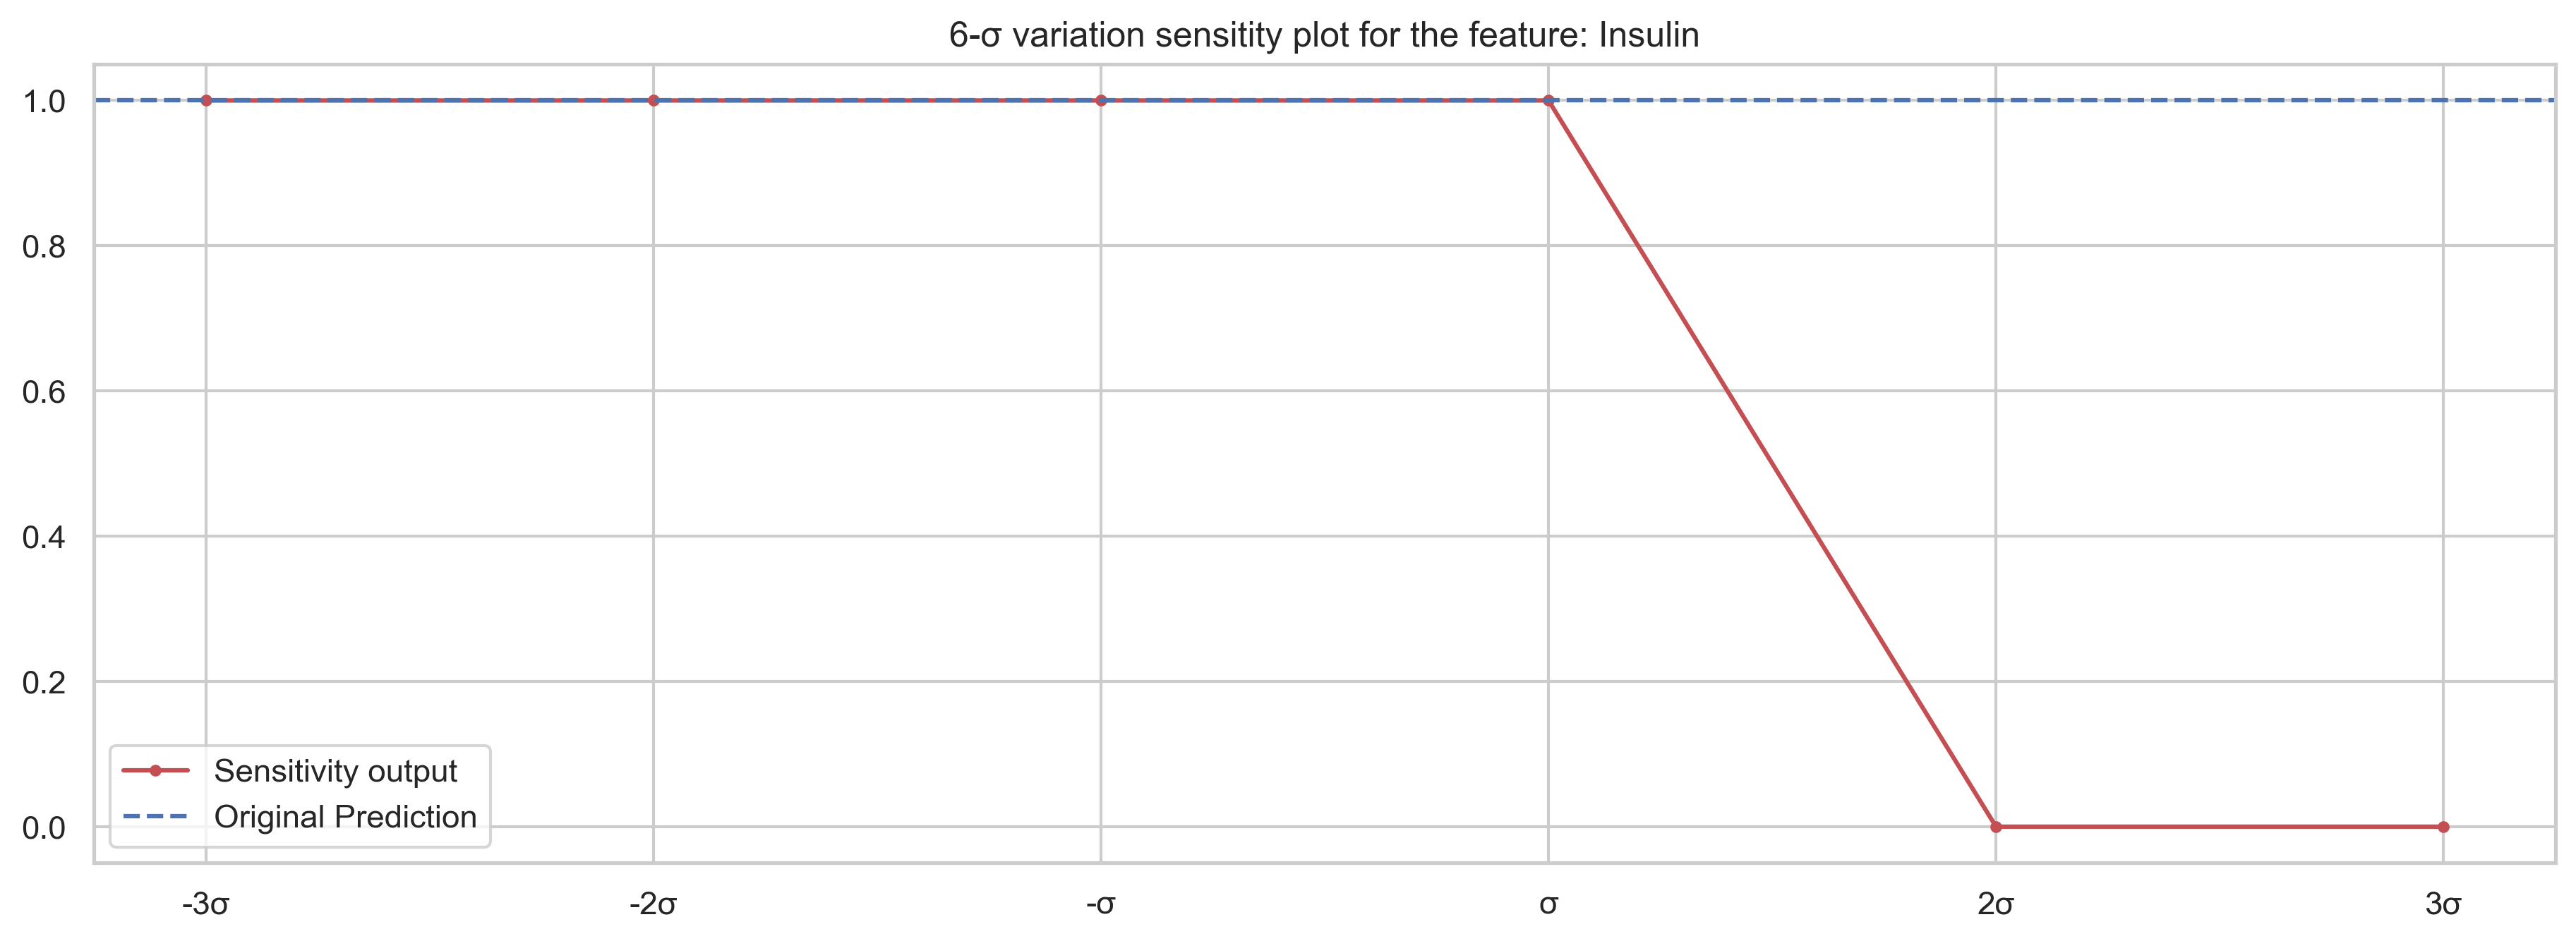

1/1 [==============================] - 0s 45ms/step


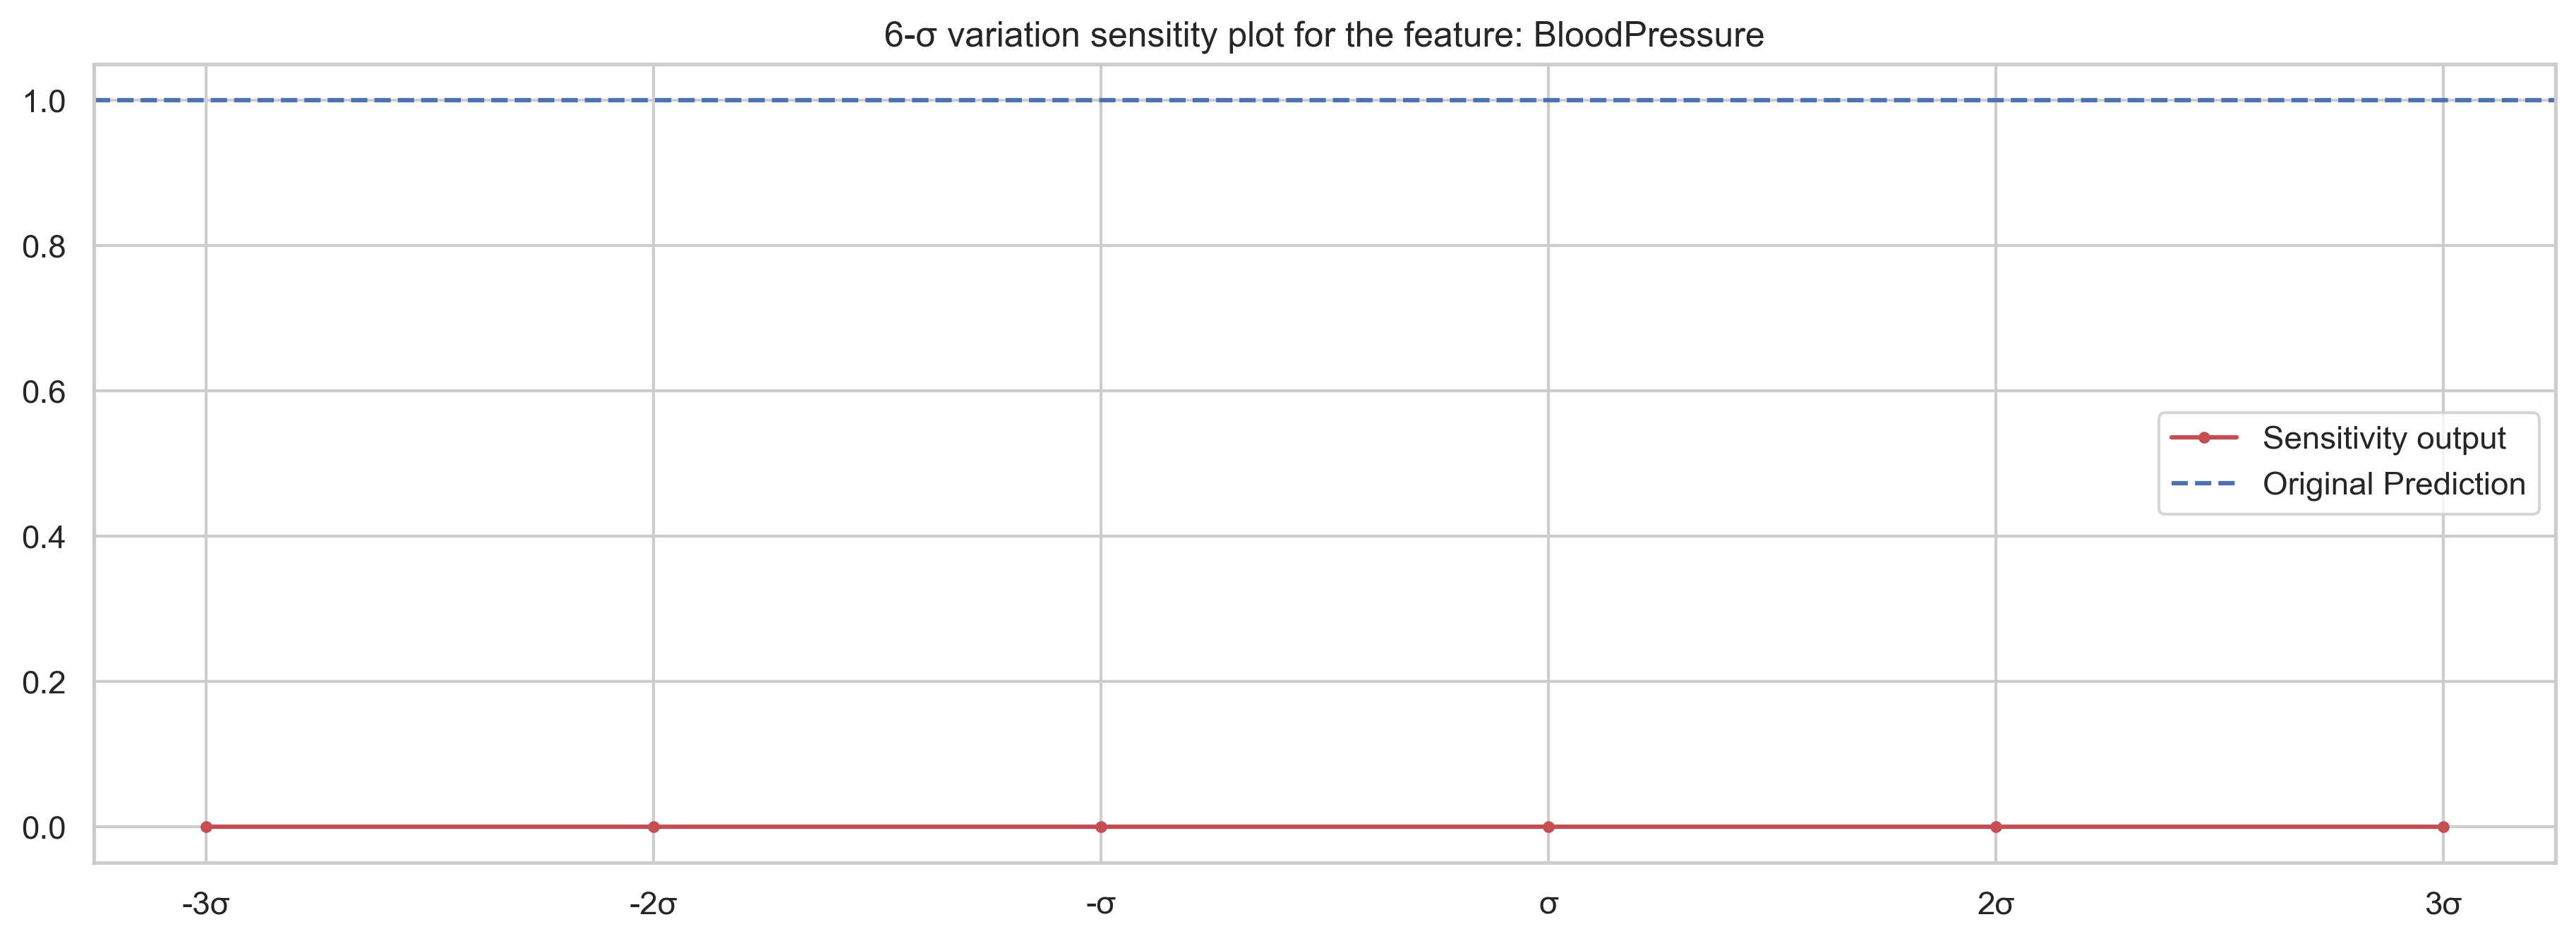

In [94]:
# Let's see the sensitivity analysis plots now
def sensitivity_analysis_plot(measure_tuple):
    '''
    Sensitivity Analysis plot using the 6-σ variation method
    '''
    (measure, sigma) = measure_tuple

    sensitivity_output = []
    original_value = df_query[measure].copy()
    for k in [-3, -2, -1, 1, 2, 3]:
        df_query[measure] = original_value.copy()
        df_query[measure] = np.clip(df_query[measure] + k * sigma, 0.0, 1.0)
        sensitivity_output.append(np.argmax(model.predict(df_query.values)))
    plt.plot(['-3σ', '-2σ', '-σ', 'σ', '2σ', '3σ'], sensitivity_output, 'r.-', label = 'Sensitivity output')
    plt.axhline(y = predicted_outcome, color = 'b', linestyle = '--', label = 'Original Prediction')
    plt.title(f'6-σ variation sensitity plot for the feature: {measure}')
    plt.legend()
    plt.show()
    
measure_tuple_list = [('Glucose', sigma_glucose),
                     ('BMI', sigma_bmi),
                     ('Age', sigma_age),
                     ('DiabetesPedigreeFunction', sigma_dpf),
                     ('Pregnancies', sigma_pregnancies),
                     ('Insulin', sigma_insulin),
                     ('BloodPressure', sigma_bp)]

for measure_tuple in measure_tuple_list:
    sensitivity_analysis_plot(measure_tuple)

Из приведенных выше графиков мы видим, насколько каждая из функций чувствительна к положительным или отрицательным изменениям и как каждая функция вносит свой вклад в влияние на результат модели.Характеристики, касающиеся инсулина, Функции родословной диабета и количества беременностей, по-видимому, не чувствительны к каким-либо изменениям. Функции, дающие информацию о глюкозе, ИМТ, кровяном давлении, по-видимому, положительно влияют на результат. Это означает, что если значения для этих признаков будут увеличены, это может привести к наличию диабета в соответствии с моделью. Удивительно, но возраст объекта оказывает негативное влияние, что означает, что если возраст увеличивается, модель становится менее чувствительной к прогнозированию исхода в виде диабета. Это противоречит нашим предыдущим знаниям и, следовательно, является довольно интересным наблюдением, требующим дальнейшего изучения.


### $$ CFE~ в~ структурированных~ данных $$

In [109]:
!pip install --upgrade pandas numpy scikit-learn tensorflow dice-ml alibi

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\1\\anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5


In [111]:
import sys
!{sys.executable} -m pip install dice_ml

  Using cached dice_ml-0.8-py3-none-any.whl (213 kB)


In [113]:
import sys
!{sys.executable} -m pip install alibi

  Using cached alibi-0.7.0-py3-none-any.whl (445 kB)
  Using cached transformers-4.21.1-py3-none-any.whl (4.7 MB)
  Using cached dill-0.3.5.1-py2.py3-none-any.whl (95 kB)
  Using cached spacy-3.4.1-cp39-cp39-win_amd64.whl (11.8 MB)
  Using cached pydantic-1.9.2-cp39-cp39-win_amd64.whl (2.0 MB)
  Using cached murmurhash-1.0.7-cp39-cp39-win_amd64.whl (18 kB)
  Using cached typer-0.4.2-py3-none-any.whl (27 kB)
  Using cached pathy-0.6.2-py3-none-any.whl (42 kB)
  Using cached cymem-2.0.6-cp39-cp39-win_amd64.whl (36 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
  Using cached thinc-8.1.0-cp39-cp39-win_amd64.whl (1.3 MB)
  Using cached preshed-3.0.6-cp39-cp39-win_amd64.whl (112 kB)
  Using cached spacy_legacy-3.0.9-py2.py3-none-any.whl (20 kB)
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached spacy_loggers-1.0.3-py3-none-any.whl (9.3 kB)
  Using cached srsly-2.4.4-cp39-cp39-win_amd64.whl (450 kB)
  Usi

In [114]:
import dice_ml as dice
import alibi
from dice_ml.utils import helpers as utils  # using helper functions as utility functions
from alibi.explainers import CounterfactualProto, Counterfactual
from sklearn.model_selection import train_test_split
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

In [115]:
data = utils.load_adult_income_dataset()
data.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [116]:
data_description = utils.get_adult_data_info()
data_description

{'age': 'age',
 'workclass': 'type of industry (Government, Other/Unknown, Private, Self-Employed)',
 'education': 'education level (Assoc, Bachelors, Doctorate, HS-grad, Masters, Prof-school, School, Some-college)',
 'marital_status': 'marital status (Divorced, Married, Separated, Single, Widowed)',
 'occupation': 'occupation (Blue-Collar, Other/Unknown, Professional, Sales, Service, White-Collar)',
 'race': 'white or other race?',
 'gender': 'male or female?',
 'hours_per_week': 'total work hours per week',
 'income': '0 (<=50K) vs 1 (>50K)'}

In [117]:
data.columns

Index(['age', 'workclass', 'education', 'marital_status', 'occupation', 'race',
       'gender', 'hours_per_week', 'income'],
      dtype='object')

data.shape

In [118]:
# Preparing the DiCE data object
data_object = dice.Data(dataframe = data,
                           continuous_features = ['age', 'hours_per_week'],
                           outcome_name = 'income'
                          )
# Loading pre-trained models using the DiCE framework
model = utils.get_adult_income_modelpath()
model_object = dice.Model(model_path = model, backend='TF2') # Creating Tensorflow 2.0 model object

In [119]:
# Creating DiCE explanation instance
dice_explanation = dice.Dice(data_object, model_object, method = 'random')

In [120]:
# Let's take a query input to generate Counterfactual Explanations
test_query = {'age':28,
    'workclass':'Self-Employed',
    'education':'HS-grad',
    'marital_status':'Single',
    'occupation':'Service',
    'race': 'Other',
    'gender':'Male',
    'hours_per_week': 45}

In [121]:
# let's generate counterfactual examples
dice_exp = dice_explanation.generate_counterfactuals(test_query,
                                                     total_CFs=3,
                                                     desired_class="opposite",
                                                     features_to_vary=["education", "occupation", "workclass", "marital_status", "hours_per_week"]
                                                    )

# And visualize counterfactual explanation
dice_exp.visualize_as_dataframe(show_only_changes=True, display_sparse_df=False)

Diverse Counterfactuals found! total time taken: 02 min 07 sec
Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28.0,Self-Employed,HS-grad,Single,Service,Other,Male,45.0,0.082



Diverse Counterfactual set without sparsity correction (new outcome:  1.0


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,-,Doctorate,Married,White-Collar,-,-,-,0.886
1,-,-,Masters,Married,-,-,-,36.0,0.775
2,-,-,Prof-school,Married,-,-,-,56.0,0.868


Из приведенного выше наблюдения мы можем ясно видеть контрафактные примеры увеличения дохода за пределы 50 тысяч долларов в год. Хотя мы можем видеть, что некоторые примеры могут быть противоречивыми, и нет количественного способа оценить лучший пример (что является основным недостатком этого алгоритма). Но мы можем четко прокомментировать, что если человек решит получить высшее образование или увеличить ставку своей работы, он может получить более высокую зарплату. Кроме того, обычно наблюдается, что, когда человек женится, годовой доход также увеличивается. Это корреляция, которая была обнаружена на основе полученных данных. Увеличение рабочего времени в неделю и рода занятий для белых воротничков также может привести к увеличению общего дохода

В целом, очень легко реализовать этот подход и понять объяснения, предоставляемые этим подходом.

Using the Alibi for Counterfactual Explanations

In [122]:
# Making some changes in the import
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs 
from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Reshape, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [123]:
# Dividing data into features and target values
target = data['income']
features = data.iloc[:,:-1]

In [124]:
# Since the dataset consists of many categorical features, we may need to encode these using One-Hot Encoding
def encode_features(df, features):
    '''
    Method for one-hot encoding all selected categorical fields
    '''
    for f in features:
        if(f in df.columns):
            encoded = pd.get_dummies(df[f])
            encoded = encoded.add_prefix(f + '_')
            df = pd.concat([df, encoded], axis=1)
        else:
            print('Feature not found')
            return df
        
    df.drop(columns=features, inplace = True)
    
    return df

In [125]:
features_to_encode = ['workclass', 'education', 'marital_status', 'occupation', 'race', 'gender']
encoded = encode_features(features, features_to_encode)
features = encoded.copy()
features.head()

,age,hours_per_week,workclass_Government,workclass_Other/Unknown,workclass_Private,workclass_Self-Employed,education_Assoc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Prof-school,education_School,education_Some-college,marital_status_Divorced,marital_status_Married,marital_status_Separated,marital_status_Single,marital_status_Widowed,occupation_Blue-Collar,occupation_Other/Unknown,occupation_Professional,occupation_Sales,occupation_Service,occupation_White-Collar,race_Other,race_White,gender_Female,gender_Male
0,28,60,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
1,30,65,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
2,32,50,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
3,20,35,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0
4,41,50,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1


In [126]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100) # 80% training and 20% test

In [127]:
def model():
    inp = Input(shape=(X_train.shape[1],))
    x = Dense(40, activation='relu')(inp)
    x = Dense(40, activation='relu')(x)
    op = Dense(2, activation='softmax')(x)
    model = Model(inputs=inp, outputs=op)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [128]:
model = model()
model.fit(X_train, to_categorical(y_train), batch_size=64, epochs=200, verbose=0)

In [129]:
# Evaluate the trained model
model.evaluate(X_test, to_categorical(y_test))[1]

0.8381958

In [130]:
query_instance = X_test.iloc[1].values.reshape((1,) + X_test.iloc[1].shape)

In [140]:
# Using Alibi's Counterfactual Prototype method to initialize explainer, fit and generate counterfactual
cf = CounterfactualProto(model, 
                         query_instance.shape, 
                         use_kdtree=True, 
                         theta=10., 
                         max_iterations=1000,
                         c_init=1., 
                         c_steps=10)
# Fit on the training data
cf.fit(X_train.values)
# Form explanation on the query data
explanation = cf.explain(query_instance)

No encoder specified. Using k-d trees to represent class prototypes.


In [141]:
print(f'Original prediction: {explanation.orig_class}')
print('Counterfactual prediction: {}'.format(explanation.cf['class']))

Original prediction: 0
Counterfactual prediction: 1


In [142]:
# Now let's see the counterfactual example
counterfactual = explanation.cf['X'].astype(int)
change = counterfactual - query_instance
df_cfe = pd.DataFrame(counterfactual, columns = features.columns)
df_cfe

,age,hours_per_week,workclass_Government,workclass_Other/Unknown,workclass_Private,workclass_Self-Employed,education_Assoc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Prof-school,education_School,education_Some-college,marital_status_Divorced,marital_status_Married,marital_status_Separated,marital_status_Single,marital_status_Widowed,occupation_Blue-Collar,occupation_Other/Unknown,occupation_Professional,occupation_Sales,occupation_Service,occupation_White-Collar,race_Other,race_White,gender_Female,gender_Male
0,26,24,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0


In [143]:
df_query = pd.DataFrame(query_instance, columns = features.columns)
df_query

,age,hours_per_week,workclass_Government,workclass_Other/Unknown,workclass_Private,workclass_Self-Employed,education_Assoc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Prof-school,education_School,education_Some-college,marital_status_Divorced,marital_status_Married,marital_status_Separated,marital_status_Single,marital_status_Widowed,occupation_Blue-Collar,occupation_Other/Unknown,occupation_Professional,occupation_Sales,occupation_Service,occupation_White-Collar,race_Other,race_White,gender_Female,gender_Male
0,26,24,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0


In [144]:
# Let's see the difference between counterfactual and original instance
for i, feature_names in enumerate(features.columns):
    if change[0][i] != 0:
        print(f"The feature {feature_names} has to change by {change[0][i]}")

Из приведенного выше наблюдения мы можем понять, что для того, чтобы доход человека превысил 50 тысяч долларов в год, ему нужно подождать еще 2 года или получить высшее образование. Как было замечено с помощью фреймворка DiCE, из-за корреляции с браком и чистым доходом из набора данных метод объяснения предлагает человеку вступить в брак. Метод также предполагает изменение типа занятия.

$$ Counterfactual~ Explanation~ on~ Unstructured~ Data $$

In [146]:
import alibi
from alibi.explainers import CounterfactualProto, Counterfactual
from sklearn.model_selection import train_test_split
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs  
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as Dataset

In [147]:
# Let's validate the tensorflow version, as otherwise the framework might have some conflicts if it is not supported.
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.9.1
Eager execution enabled:  False


In [148]:
mnist_data = Dataset.mnist.load_data()
train_data, test_data = mnist_data
x_train, y_train = train_data
x_test, y_test = test_data

11490434/11490434 [==============================] - 107s 9us/step


In [149]:
print(f"Shape of training data features:{x_train.shape}")
print(f"Shape of test data features:{x_test.shape}")

Shape of training data features:(60000, 28, 28)
Shape of test data features:(10000, 28, 28)


Итак, мы видим, что каждое изображение имеет размер (28x28) и содержит 60 000 выборок для обучающих данных и 10 000 выборок для тестовых данных. Теперь давайте даже визуализируем некоторые образцы.

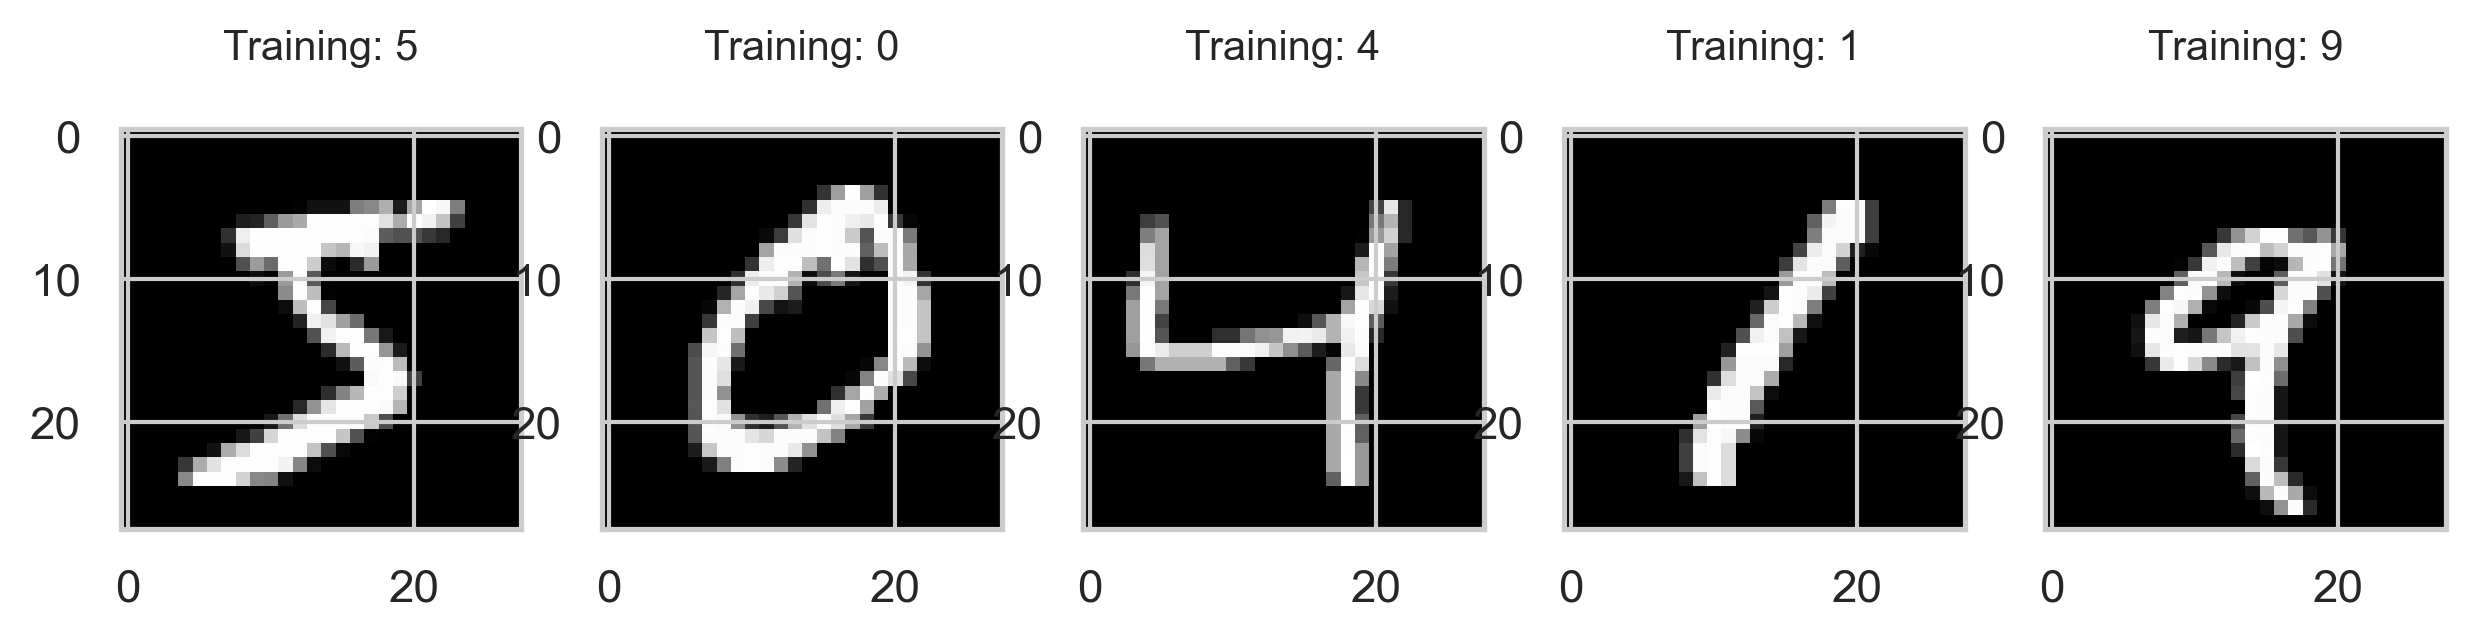

In [150]:
plt.figure(figsize=(10,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 10)

Data Preparation

In [151]:
x_train = x_train/ 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)

# Using Min-Max Normalizer
MIN, MAX = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (MAX - MIN) + MIN
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (MAX - MIN) + MIN

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)


Training a CNN model

In [ ]:
x_in = Input(shape=(28, 28, 1))
x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x_out = Dense(10, activation='softmax')(x)

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, to_categorical(y_train), batch_size=64, epochs=500, verbose=0)

In [ ]:
model.evaluate(x_test, to_categorical(y_test), verbose=0)[1]

Теперь давайте посмотрим, как использовать фреймворк Alibi для генерации контрафактных примеров. Сначала нам нужно будет сгенерировать модель, которая поддерживается фреймворком Alibi. Мы применим метод управляемого прототипа, который использует модель автоматического кодирования. Итак, давайте теперь определим модель автоматического кодирования.

In [ ]:
# Encoder model
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded_features = Conv2D(1, (3, 3), activation=None, padding='same')(x)
encoder = Model(x_in, encoded_features)

In [ ]:
# Decoder model
dec_in = Input(shape=(14, 14, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
decoded_features = Conv2D(1, (3, 3), activation=None, padding='same')(x)
decoder = Model(dec_in, decoded_features)

In [ ]:
# Autoencoder model
x_out = decoder(encoder(x_in))
autoencoder = Model(x_in, x_out)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Defining the counterfactual parameters
shape = (1, 28, 28, 1)
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

In [ ]:
# Create the explainer, fit to generate counterfactual examples
def generate_CFE(query_instance):
    '''
    Method to generate counterfactual explanations using the guided prototype method
    '''
    # define a black-box model
    predict_fn = lambda x: model.predict(x)
    
    cf = CounterfactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                             ae_model=autoencoder, enc_model=encoder, max_iterations=max_iterations,
                             feature_range=feature_range, c_init=c_init, c_steps=c_steps)

    cf.fit(x_train)  # find class prototypes
    explanation = cf.explain(query_instance, k=3, k_type='mean') # Prototypes defined by knn method
    return explanation

In [ ]:
def generate_examples():
    '''
    Function to generate CFE for query instances
    '''
    for i in range(23,24): # Change this value to experiment with other ranges
        plt.subplot(1, 2, 1)
        plt.title('Original Instance:')
        query_instance = x_test[i].reshape((1,) + x_test[i].shape)
        plt.imshow(query_instance.reshape(28, 28), cmap=plt.cm.gray);
        explanation = generate_CFE(query_instance)
        print('Counterfactual prediction: {}'.format(explanation.cf['class']))
        print(f'Closest prototype class: {explanation.id_proto}')
        plt.subplot(1, 2, 2)
        plt.title('Generated CFE:')
        plt.imshow(explanation.cf['X'].reshape(28, 28), cmap=plt.cm.gray);
        plt.show()

In [ ]:
generate_examples()

Из приведенного выше примера мы можем ясно видеть, что экземпляр запроса, который предназначен для написанной от руки цифры 5 и после применения метода CFE, предсказал контрафактный результат как 9. Хотя ближайший прототип - 6. Интуитивно говоря, написанная от руки цифра 5 может выглядеть как 9 или 6 в зависимости от стиля рукописного ввода. Итак, этот метод был довольно интересным.